# Model downloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_сifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_stylegan2_ada = os.path.join(cwd, '..', 'tools', 'stylegan2_ada_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')

sys.path.append(api_path_сifar)
sys.path.append(api_path_stylegan2_ada)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

In [3]:
import os
import re
from typing import List, Optional

import click
import numpy as np
import PIL.Image
import torch
import random
from functools import partial

import legacy
import dnnlib

from matplotlib import pyplot as plt

In [4]:
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy,
                          gan_energy_stylegan2_ada)

from sir_ais_sampling import sir_independent_dynamics_sampling

from cifar10_utils import (plot_images, 
                           save_images_for_fid,
                           save_images_for_fid_fix_latent,
                           z_transform,
                           delete_nan_samples,
                           delete_local_files,
                           delete_saved_files_for_cifar10_statistics,
                           calculate_cifar10_statistics,
                           plot_scores_cifar10_dynamics)

from dataloader import get_loader

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from general_utils import to_var, DotDict, to_np

In [5]:
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'

device = torch.device('cuda:1')
with dnnlib.util.open_url(network_pkl) as f:
    file = legacy.load_network_pkl(f)
    G = file['G_ema'].to(device)
    D = file['D'].to(device)
G = G.eval().requires_grad_(False).to(device)
D = D.eval().requires_grad_(False).to(device)


In [40]:
truncation_psi = 1
noise_mode = 'const'

In [41]:
seed = 42
batch_size = 64
z = torch.from_numpy(np.random.RandomState(seed).randn(batch_size, G.z_dim)).to(device)
label = torch.zeros([batch_size, G.c_dim], device=device)
img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
img_numpy = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()

In [42]:
img = G(z, label)

In [43]:
img.max()

tensor(1.1139, device='cuda:1')

In [43]:
def plot_images(images_numpy):
    batch_size_sample = images_numpy.shape[0]
    nrow = int(batch_size_sample**0.5)
    fig = plt.figure(figsize=(15, 15))
    axes = fig.subplots(nrow, nrow)
    for k in range(batch_size_sample):
        i = k // nrow
        j = k % nrow
        #axes[i][j].imshow(np.clip(numpy_images[k], 0, 1))
        axes[i][j].imshow(images_numpy[k])
        axes[i][j].axis('off')
    plt.show()

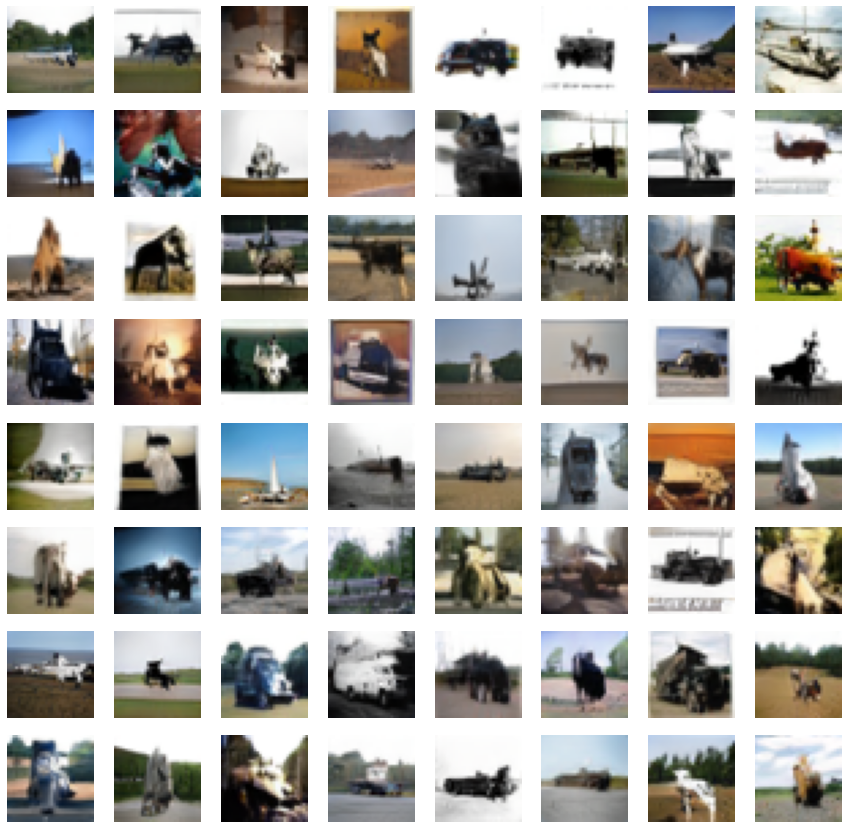

In [44]:
plot_images(img_numpy)

In [21]:
result = D(img, label)

In [23]:
label.shape

torch.Size([64, 10])

# Calculating metrics from repo dataset

In [10]:
from simple_calc_metrics import calc_metrics

metrics = ['fid50k_full']
mirror = 0 # FALSE/TRUE?????
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'
gpus = 1
verbose = True
data = '/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip'
ctx = None

In [11]:
calc_metrics(ctx, network_pkl, metrics, data, mirror, gpus, verbose)

list of valid metrics = ['fid50k_full', 'kid50k_full', 'pr50k3_full', 'ppl2_wend', 'is50k', 'fid50k', 'kid50k', 'pr50k3', 'ppl_zfull', 'ppl_wfull', 'ppl_zend', 'ppl_wend']
Loading network from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl"...
Dataset options:
{
  "class_name": "training.dataset.ImageFolderDataset",
  "path": "/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip",
  "resolution": 32,
  "use_labels": true,
  "xflip": 0
}
Launching processes...

Generator            Parameters  Buffers  Output shape      Datatype
---                  ---         ---      ---               ---     
mapping.embed        5632        -        [1, 512]          float32 
mapping.fc0          524800      -        [1, 512]          float32 
mapping.fc1          262656      -        [1, 512]          float32 
mapping              -           512      [1, 8, 512]       float32 
synthesis.b4.conv1   2622465     32       [1, 512, 4, 4]    float32 
synthesis.b4.torgb 

In [6]:
from simple_calc_metrics import calc_metrics

metrics = ['fid50k_full']
mirror = 0 # FALSE/TRUE?????
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'
gpus = 1
verbose = True
data = '/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip'
ctx = None

In [7]:
calc_metrics(ctx, network_pkl, metrics, data, mirror, gpus, verbose)

list of valid metrics = ['fid50k_full', 'kid50k_full', 'pr50k3_full', 'ppl2_wend', 'is50k', 'fid50k', 'kid50k', 'pr50k3', 'ppl_zfull', 'ppl_wfull', 'ppl_zend', 'ppl_wend']
Loading network from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl"...
Dataset options:
{
  "class_name": "training.dataset.ImageFolderDataset",
  "path": "/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip",
  "resolution": 32,
  "use_labels": true,
  "xflip": 0
}
Launching processes...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.

Generator            Parameters  Buffers  Output shape      Datatype
---                  ---         ---      ---               ---     
mapping.embed        5632        -        [1, 512]          float32 
mapping.fc0          524800      -        [1, 512]          float32 
mapping.fc1          262656      -        [1, 512]          float32 
mapping              -           512      [1, 8, 5

generator features  items 12288   time 58s          ms/item 4.70
generator features  items 13312   time 1m 03s       ms/item 4.67
generator features  items 14336   time 1m 07s       ms/item 4.68
generator features  items 15360   time 1m 12s       ms/item 4.69
generator features  items 16384   time 1m 17s       ms/item 4.66
generator features  items 17408   time 1m 22s       ms/item 4.66
generator features  items 18432   time 1m 26s       ms/item 4.66
generator features  items 19456   time 1m 31s       ms/item 4.66
generator features  items 20480   time 1m 36s       ms/item 4.66
generator features  items 21504   time 1m 41s       ms/item 4.67
generator features  items 22528   time 1m 46s       ms/item 4.66
generator features  items 23552   time 1m 50s       ms/item 4.64
generator features  items 24576   time 1m 55s       ms/item 4.69
generator features  items 25600   time 2m 00s       ms/item 4.68
generator features  items 26624   time 2m 05s       ms/item 4.67
generator features  items

 10%|9         | 78/782 [32:04<4:49:26, 24.67s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4992.npy was saved, file shape = (21, 64, 512)


 20%|#9        | 156/782 [1:04:07<4:17:22, 24.67s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9984.npy was saved, file shape = (21, 64, 512)


 30%|##9       | 232/782 [1:35:23<3:46:22, 24.70s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_14848.npy was saved, file shape = (21, 64, 512)


 39%|###9      | 308/782 [2:06:38<3:14:47, 24.66s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_19712.npy was saved, file shape = (21, 64, 512)


 49%|####9     | 384/782 [2:37:53<2:43:34, 24.66s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_24576.npy was saved, file shape = (21, 64, 512)


 59%|#####8    | 460/782 [3:09:07<2:12:22, 24.67s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_29440.npy was saved, file shape = (21, 64, 512)


 69%|######8   | 536/782 [3:40:21<1:41:07, 24.66s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_34304.npy was saved, file shape = (21, 64, 512)


 78%|#######8  | 612/782 [4:11:36<1:09:53, 24.67s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_39168.npy was saved, file shape = (21, 64, 512)


 88%|########8 | 689/782 [4:43:16<38:15, 24.68s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_44096.npy was saved, file shape = (21, 64, 512)


 98%|#########8| 767/782 [5:15:21<06:10, 24.68s/it]file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_49088.npy was saved, file shape = (21, 64, 512)


100%|##########| 782/782 [5:21:31<00:00, 24.67s/it]


# ULA

In [45]:
loc = torch.zeros(G.z_dim).to(device)
scale = torch.ones(G.z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

In [46]:
log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy_stylegan2_ada,
                     generator = G, 
                     discriminator = D, 
                     truncation_psi = truncation_psi,
                     noise_mode = noise_mode,
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 64
n = 50000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_stylegan2_ada'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)


In [8]:
batch_size = 64
n = 50000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_stylegan2_ada'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'

load_ula_batches = load_data_from_batches(n, batch_size, path_to_save, file_name)

100%|██████████| 782/782 [00:01<00:00, 673.38it/s]


In [29]:
load_ula_batches.shape

(21, 50048, 512)

# Metrics for latent dataset

In [ ]:
from calc_metrics_from_latent_dataset import calc_metric
import metrics_stylegan2_ada.metric_utils as metric_utils

In [22]:
import copy
metrics = ['fid50k_full_for_latent_dataset']
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'
gpus = 1
verbose = True
data = '/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip'
args = dnnlib.EasyDict(metrics=metrics, num_gpus=gpus, network_pkl=network_pkl, verbose=verbose)
args.G = G
args.dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path=data)
args.dataset_kwargs.resolution = args.G.img_resolution
args.dataset_kwargs.use_labels = (args.G.c_dim != 0)
device = torch.device('cuda:1')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
G = copy.deepcopy(args.G).eval().requires_grad_(False).to(device)
test_tensor = torch.randn([50048, G.z_dim])

In [23]:
rank = 0
all_dicts = []
for metric in args.metrics:
    print(f'Calculating {metric}...')
    progress = metric_utils.ProgressMonitor(verbose=args.verbose)
    result_dict = calc_metric(metric=metric, G=G, dataset_kwargs=args.dataset_kwargs,
        num_gpus=args.num_gpus, rank=rank, device=device, progress=progress,
                             latent_dataset = test_tensor)
    all_dicts.append(result_dict)

Calculating fid50k_full_for_latent_dataset...
latent dataset features items 1024    time 4s           ms/item 3.89
latent dataset features items 2048    time 8s           ms/item 3.57
latent dataset features items 3072    time 11s          ms/item 3.58
latent dataset features items 4096    time 15s          ms/item 3.58
latent dataset features items 5120    time 19s          ms/item 3.58
latent dataset features items 6144    time 22s          ms/item 3.59
latent dataset features items 7168    time 26s          ms/item 3.60
latent dataset features items 8192    time 30s          ms/item 3.61
latent dataset features items 9216    time 33s          ms/item 3.62
latent dataset features items 10240   time 37s          ms/item 3.62
latent dataset features items 11264   time 41s          ms/item 3.63
latent dataset features items 12288   time 45s          ms/item 3.63
latent dataset features items 13312   time 48s          ms/item 3.64
latent dataset features items 14336   time 52s          m

In [24]:
all_dicts

[{'results': {'fid50k_latent_mean': 2.399419608647132,
   'fid50k_latent_std': 3.9221677620402375e-06},
  'metric': 'fid50k_full_for_latent_dataset',
  'total_time': 269.6539707183838,
  'total_time_str': '4m 30s'}]

In [26]:
all_dicts[0]['results']

{'fid50k_latent_mean': 2.399419608647132,
 'fid50k_latent_std': 3.9221677620402375e-06}

In [9]:
from calc_metrics_from_latent_dataset import pipeline_for_latent_dataset

data = '/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip'
device = torch.device('cuda:1')
load_batches = load_ula_batches
every_step = 5
method_name = 'ula_stylegan2_ada'
path_to_save_cifar10_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'

res_metrics = pipeline_for_latent_dataset(G, device, data, load_batches, 
                                          path_to_save_cifar10_np, method_name, every_step)

------------------------------------
step = 0
sample size = (50048, 512)
sample size after deleteting nans = (50048, 512)
Calculating is50k_for_latent_dataset...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
latent dataset features items 1024    time 6s           ms/item 6.15
latent dataset features items 2048    time 10s          ms/item 3.59
latent dataset features items 3072    time 14s          ms/item 3.59
latent dataset features items 4096    time 17s          ms/item 3.60
latent dataset features items 5120    time 21s          ms/item 3.61
latent dataset features items 6144    time 25s          ms/item 3.62
latent dataset features items 7168    time 28s          ms/item 3.62
latent dataset features items 8192    time 32s          ms/item 3.63
latent dataset features items 9216    time 36s          ms/item 3.64
latent dataset features items 10240   time 40s          ms/item 3.64
latent dataset features items 11264   tim

latent dataset features items 11264   time 41s          ms/item 3.69
latent dataset features items 12288   time 45s          ms/item 3.68
latent dataset features items 13312   time 49s          ms/item 3.69
latent dataset features items 14336   time 53s          ms/item 3.70
latent dataset features items 15360   time 56s          ms/item 3.70
latent dataset features items 16384   time 1m 00s       ms/item 3.71
latent dataset features items 17408   time 1m 04s       ms/item 3.72
latent dataset features items 18432   time 1m 08s       ms/item 3.72
latent dataset features items 19456   time 1m 12s       ms/item 3.72
latent dataset features items 20480   time 1m 15s       ms/item 3.73
latent dataset features items 21504   time 1m 19s       ms/item 3.74
latent dataset features items 22528   time 1m 23s       ms/item 3.76
latent dataset features items 23552   time 1m 27s       ms/item 3.77
latent dataset features items 24576   time 1m 31s       ms/item 3.79
latent dataset features items 2560

latent dataset features items 25600   time 1m 36s       ms/item 3.84
latent dataset features items 26624   time 1m 40s       ms/item 3.85
latent dataset features items 27648   time 1m 44s       ms/item 3.84
latent dataset features items 28672   time 1m 48s       ms/item 3.84
latent dataset features items 29696   time 1m 52s       ms/item 3.85
latent dataset features items 30720   time 1m 56s       ms/item 3.85
latent dataset features items 31744   time 2m 00s       ms/item 3.84
latent dataset features items 32768   time 2m 04s       ms/item 3.84
latent dataset features items 33792   time 2m 08s       ms/item 3.84
latent dataset features items 34816   time 2m 12s       ms/item 3.84
latent dataset features items 35840   time 2m 16s       ms/item 3.84
latent dataset features items 36864   time 2m 20s       ms/item 3.84
latent dataset features items 37888   time 2m 23s       ms/item 3.84
latent dataset features items 38912   time 2m 27s       ms/item 3.85
latent dataset features items 3993

latent dataset features items 39936   time 2m 32s       ms/item 3.90
latent dataset features items 40960   time 2m 36s       ms/item 3.90
latent dataset features items 41984   time 2m 40s       ms/item 3.89
latent dataset features items 43008   time 2m 44s       ms/item 3.90
latent dataset features items 44032   time 2m 48s       ms/item 3.90
latent dataset features items 45056   time 2m 52s       ms/item 3.89
latent dataset features items 46080   time 2m 56s       ms/item 3.90
latent dataset features items 47104   time 3m 00s       ms/item 3.90
latent dataset features items 48128   time 3m 04s       ms/item 3.89
latent dataset features items 49152   time 3m 08s       ms/item 3.89
latent dataset features items 50000   time 3m 11s       ms/item 4.11
Calculating fid50k_full_for_latent_dataset...
latent dataset features items 1024    time 4s           ms/item 3.93
latent dataset features items 2048    time 8s           ms/item 3.87
latent dataset features items 3072    time 12s          m

latent dataset features items 3072    time 12s          ms/item 3.83
latent dataset features items 4096    time 16s          ms/item 3.82
latent dataset features items 5120    time 20s          ms/item 3.83
latent dataset features items 6144    time 24s          ms/item 3.83
latent dataset features items 7168    time 27s          ms/item 3.82
latent dataset features items 8192    time 31s          ms/item 3.84
latent dataset features items 9216    time 35s          ms/item 3.82
latent dataset features items 10240   time 39s          ms/item 3.83
latent dataset features items 11264   time 43s          ms/item 3.82
latent dataset features items 12288   time 47s          ms/item 3.83
latent dataset features items 13312   time 51s          ms/item 3.83
latent dataset features items 14336   time 55s          ms/item 3.83
latent dataset features items 15360   time 59s          ms/item 3.82
latent dataset features items 16384   time 1m 03s       ms/item 3.82
latent dataset features items 1740

latent dataset features items 17408   time 1m 07s       ms/item 3.83
latent dataset features items 18432   time 1m 11s       ms/item 3.81
latent dataset features items 19456   time 1m 15s       ms/item 3.84
latent dataset features items 20480   time 1m 19s       ms/item 3.83
latent dataset features items 21504   time 1m 23s       ms/item 3.83
latent dataset features items 22528   time 1m 26s       ms/item 3.82
latent dataset features items 23552   time 1m 30s       ms/item 3.82
latent dataset features items 24576   time 1m 34s       ms/item 3.82
latent dataset features items 25600   time 1m 38s       ms/item 3.82
latent dataset features items 26624   time 1m 42s       ms/item 3.82
latent dataset features items 27648   time 1m 46s       ms/item 3.83
latent dataset features items 28672   time 1m 50s       ms/item 3.82
latent dataset features items 29696   time 1m 54s       ms/item 3.82
latent dataset features items 30720   time 1m 58s       ms/item 3.82
latent dataset features items 3174

latent dataset features items 31744   time 2m 02s       ms/item 3.81
latent dataset features items 32768   time 2m 06s       ms/item 3.82
latent dataset features items 33792   time 2m 10s       ms/item 3.82
latent dataset features items 34816   time 2m 13s       ms/item 3.81
latent dataset features items 35840   time 2m 17s       ms/item 3.82
latent dataset features items 36864   time 2m 21s       ms/item 3.81
latent dataset features items 37888   time 2m 25s       ms/item 3.82
latent dataset features items 38912   time 2m 29s       ms/item 3.86
latent dataset features items 39936   time 2m 33s       ms/item 3.88
latent dataset features items 40960   time 2m 37s       ms/item 3.88
latent dataset features items 41984   time 2m 41s       ms/item 3.90
latent dataset features items 43008   time 2m 45s       ms/item 3.89
latent dataset features items 44032   time 2m 49s       ms/item 3.88
latent dataset features items 45056   time 2m 53s       ms/item 3.87
latent dataset features items 4608

latent dataset features items 46080   time 2m 58s       ms/item 3.83
latent dataset features items 47104   time 3m 02s       ms/item 3.84
latent dataset features items 48128   time 3m 06s       ms/item 3.86
latent dataset features items 49152   time 3m 10s       ms/item 3.85
latent dataset features items 50000   time 3m 13s       ms/item 4.07
split = 0
split = 1
split = 2
split = 3
split = 4
split = 5
split = 6
split = 7
split = 8
split = 9
ula_stylegan2_ada mean inception score = 10.03285026550293, std inception score = 0.09662678092718124
FID score for train CIFAR10 with ula_stylegan2_ada: mean 2.732492140796805, score 3.7890235761556555e-06
------------------------------------
step = 40
sample size = (50048, 512)
sample size after deleteting nans = (50048, 512)
Calculating is50k_for_latent_dataset...
latent dataset features items 1024    time 4s           ms/item 3.78
latent dataset features items 2048    time 8s           ms/item 3.68
latent dataset features items 3072    time 11s 

latent dataset features items 3072    time 11s          ms/item 3.68
latent dataset features items 4096    time 15s          ms/item 3.68
latent dataset features items 5120    time 19s          ms/item 3.70
latent dataset features items 6144    time 23s          ms/item 3.71
latent dataset features items 7168    time 27s          ms/item 3.72
latent dataset features items 8192    time 30s          ms/item 3.73
latent dataset features items 9216    time 34s          ms/item 3.73
latent dataset features items 10240   time 38s          ms/item 3.74
latent dataset features items 11264   time 42s          ms/item 3.74
latent dataset features items 12288   time 46s          ms/item 3.75
latent dataset features items 13312   time 50s          ms/item 3.75
latent dataset features items 14336   time 53s          ms/item 3.76
latent dataset features items 15360   time 57s          ms/item 3.77
latent dataset features items 16384   time 1m 01s       ms/item 3.76
latent dataset features items 1740

latent dataset features items 17408   time 1m 04s       ms/item 3.72
latent dataset features items 18432   time 1m 08s       ms/item 3.72
latent dataset features items 19456   time 1m 12s       ms/item 3.72
latent dataset features items 20480   time 1m 16s       ms/item 3.72
latent dataset features items 21504   time 1m 19s       ms/item 3.74
latent dataset features items 22528   time 1m 23s       ms/item 3.78
latent dataset features items 23552   time 1m 27s       ms/item 3.78
latent dataset features items 24576   time 1m 31s       ms/item 3.79
latent dataset features items 25600   time 1m 35s       ms/item 3.80
latent dataset features items 26624   time 1m 39s       ms/item 3.80
latent dataset features items 27648   time 1m 43s       ms/item 3.81
latent dataset features items 28672   time 1m 47s       ms/item 3.83
latent dataset features items 29696   time 1m 50s       ms/item 3.82
latent dataset features items 30720   time 1m 54s       ms/item 3.86
latent dataset features items 3174

latent dataset features items 31744   time 2m 00s       ms/item 3.90
latent dataset features items 32768   time 2m 04s       ms/item 3.90
latent dataset features items 33792   time 2m 08s       ms/item 3.90
latent dataset features items 34816   time 2m 12s       ms/item 3.90
latent dataset features items 35840   time 2m 16s       ms/item 3.90
latent dataset features items 36864   time 2m 20s       ms/item 3.88
latent dataset features items 37888   time 2m 24s       ms/item 3.90
latent dataset features items 38912   time 2m 28s       ms/item 3.89
latent dataset features items 39936   time 2m 32s       ms/item 3.89
latent dataset features items 40960   time 2m 36s       ms/item 3.89
latent dataset features items 41984   time 2m 40s       ms/item 3.90
latent dataset features items 43008   time 2m 44s       ms/item 3.90
latent dataset features items 44032   time 2m 48s       ms/item 3.89
latent dataset features items 45056   time 2m 52s       ms/item 3.89
latent dataset features items 4608

latent dataset features items 46080   time 2m 55s       ms/item 3.89
latent dataset features items 47104   time 2m 59s       ms/item 3.89
latent dataset features items 48128   time 3m 03s       ms/item 3.90
latent dataset features items 49152   time 3m 07s       ms/item 3.89
latent dataset features items 50000   time 3m 10s       ms/item 4.11
Calculating fid50k_full_for_latent_dataset...
latent dataset features items 1024    time 4s           ms/item 3.94
latent dataset features items 2048    time 8s           ms/item 3.88
latent dataset features items 3072    time 12s          ms/item 3.87
latent dataset features items 4096    time 16s          ms/item 3.88
latent dataset features items 5120    time 20s          ms/item 3.84
latent dataset features items 6144    time 24s          ms/item 3.85
latent dataset features items 7168    time 28s          ms/item 3.83
latent dataset features items 8192    time 32s          ms/item 3.84
latent dataset features items 9216    time 36s          m

latent dataset features items 9216    time 35s          ms/item 3.83
latent dataset features items 10240   time 39s          ms/item 3.83
latent dataset features items 11264   time 43s          ms/item 3.84
latent dataset features items 12288   time 47s          ms/item 3.83
latent dataset features items 13312   time 51s          ms/item 3.84
latent dataset features items 14336   time 55s          ms/item 3.84
latent dataset features items 15360   time 59s          ms/item 3.83
latent dataset features items 16384   time 1m 03s       ms/item 3.83
latent dataset features items 17408   time 1m 07s       ms/item 3.83
latent dataset features items 18432   time 1m 11s       ms/item 3.83
latent dataset features items 19456   time 1m 15s       ms/item 3.84
latent dataset features items 20480   time 1m 19s       ms/item 3.82
latent dataset features items 21504   time 1m 22s       ms/item 3.84
latent dataset features items 22528   time 1m 26s       ms/item 3.83
latent dataset features items 2355

latent dataset features items 23552   time 1m 31s       ms/item 3.85
latent dataset features items 24576   time 1m 35s       ms/item 3.85
latent dataset features items 25600   time 1m 39s       ms/item 3.85
latent dataset features items 26624   time 1m 43s       ms/item 3.86
latent dataset features items 27648   time 1m 47s       ms/item 3.86
latent dataset features items 28672   time 1m 51s       ms/item 3.87
latent dataset features items 29696   time 1m 55s       ms/item 3.85
latent dataset features items 30720   time 1m 59s       ms/item 3.85
latent dataset features items 31744   time 2m 03s       ms/item 3.85
latent dataset features items 32768   time 2m 07s       ms/item 3.84
latent dataset features items 33792   time 2m 10s       ms/item 3.86
latent dataset features items 34816   time 2m 14s       ms/item 3.86
latent dataset features items 35840   time 2m 18s       ms/item 3.84
latent dataset features items 36864   time 2m 22s       ms/item 3.85
latent dataset features items 3788

latent dataset features items 37888   time 2m 26s       ms/item 3.82
latent dataset features items 38912   time 2m 30s       ms/item 3.82
latent dataset features items 39936   time 2m 34s       ms/item 3.84
latent dataset features items 40960   time 2m 38s       ms/item 3.80
latent dataset features items 41984   time 2m 42s       ms/item 3.82
latent dataset features items 43008   time 2m 46s       ms/item 3.81
latent dataset features items 44032   time 2m 50s       ms/item 3.80
latent dataset features items 45056   time 2m 54s       ms/item 3.81
latent dataset features items 46080   time 2m 58s       ms/item 3.80
latent dataset features items 47104   time 3m 01s       ms/item 3.81
latent dataset features items 48128   time 3m 05s       ms/item 3.79
latent dataset features items 49152   time 3m 09s       ms/item 3.80
latent dataset features items 50000   time 3m 13s       ms/item 4.06
split = 0
split = 1
split = 2
split = 3
split = 4
split = 5
split = 6
split = 7
split = 8
split = 9
ula

split = 2
split = 3
split = 4
split = 5
split = 6
split = 7
split = 8
split = 9
ula_stylegan2_ada mean inception score = 10.178472518920898, std inception score = 0.12806926667690277
FID score for train CIFAR10 with ula_stylegan2_ada: mean 3.5412124729134575, score 3.015317536876831e-06
------------------------------------
step = 85
sample size = (50048, 512)
sample size after deleteting nans = (50048, 512)
Calculating is50k_for_latent_dataset...
latent dataset features items 1024    time 4s           ms/item 3.71
latent dataset features items 2048    time 8s           ms/item 3.62
latent dataset features items 3072    time 11s          ms/item 3.64
latent dataset features items 4096    time 15s          ms/item 3.64
latent dataset features items 5120    time 19s          ms/item 3.65
latent dataset features items 6144    time 22s          ms/item 3.65
latent dataset features items 7168    time 26s          ms/item 3.66
latent dataset features items 8192    time 30s          ms/item 3.

latent dataset features items 8192    time 31s          ms/item 3.74
latent dataset features items 9216    time 34s          ms/item 3.75
latent dataset features items 10240   time 38s          ms/item 3.75
latent dataset features items 11264   time 42s          ms/item 3.75
latent dataset features items 12288   time 46s          ms/item 3.76
latent dataset features items 13312   time 50s          ms/item 3.77
latent dataset features items 14336   time 54s          ms/item 3.77
latent dataset features items 15360   time 58s          ms/item 3.77
latent dataset features items 16384   time 1m 01s       ms/item 3.78
latent dataset features items 17408   time 1m 05s       ms/item 3.79
latent dataset features items 18432   time 1m 09s       ms/item 3.79
latent dataset features items 19456   time 1m 13s       ms/item 3.80
latent dataset features items 20480   time 1m 17s       ms/item 3.81
latent dataset features items 21504   time 1m 21s       ms/item 3.83
latent dataset features items 2252

latent dataset features items 22528   time 1m 24s       ms/item 3.82
latent dataset features items 23552   time 1m 28s       ms/item 3.84
latent dataset features items 24576   time 1m 32s       ms/item 3.84
latent dataset features items 25600   time 1m 36s       ms/item 3.85
latent dataset features items 26624   time 1m 40s       ms/item 3.84
latent dataset features items 27648   time 1m 44s       ms/item 3.85
latent dataset features items 28672   time 1m 48s       ms/item 3.86
latent dataset features items 29696   time 1m 52s       ms/item 3.86
latent dataset features items 30720   time 1m 56s       ms/item 3.87
latent dataset features items 31744   time 2m 00s       ms/item 3.85
latent dataset features items 32768   time 2m 04s       ms/item 3.87
latent dataset features items 33792   time 2m 08s       ms/item 3.85
latent dataset features items 34816   time 2m 12s       ms/item 3.86
latent dataset features items 35840   time 2m 16s       ms/item 3.87
latent dataset features items 3686

latent dataset features items 36864   time 2m 20s       ms/item 3.86
latent dataset features items 37888   time 2m 24s       ms/item 3.82
latent dataset features items 38912   time 2m 28s       ms/item 3.84
latent dataset features items 39936   time 2m 32s       ms/item 3.84
latent dataset features items 40960   time 2m 36s       ms/item 3.84
latent dataset features items 41984   time 2m 40s       ms/item 3.84
latent dataset features items 43008   time 2m 44s       ms/item 3.84
latent dataset features items 44032   time 2m 48s       ms/item 3.84
latent dataset features items 45056   time 2m 52s       ms/item 3.84
latent dataset features items 46080   time 2m 56s       ms/item 3.84
latent dataset features items 47104   time 3m 00s       ms/item 3.85
latent dataset features items 48128   time 3m 04s       ms/item 3.84
latent dataset features items 49152   time 3m 08s       ms/item 3.83
latent dataset features items 50000   time 3m 11s       ms/item 4.05
Calculating fid50k_full_for_latent

In [10]:
print(res_metrics)

{'inception_scores_mean': array([10.05457497, 10.07034588, 10.04864311, 10.06538868, 10.05094147,
       10.02783298, 10.0841732 , 10.03285027, 10.09862709, 10.13711643,
       10.13527107, 10.08882713, 10.1171627 , 10.1826973 , 10.07479286,
       10.08789635, 10.17847252, 10.11877728, 10.18039894, 10.13741112,
       10.14778328]), 'inception_scores_std': array([0.12446968, 0.11578986, 0.08600371, 0.14900838, 0.11094294,
       0.13810332, 0.14048803, 0.09662678, 0.11959448, 0.11174425,
       0.1472986 , 0.14348945, 0.16736422, 0.10053983, 0.12027297,
       0.07977252, 0.12806927, 0.11789369, 0.08615606, 0.11256246,
       0.08302391]), 'fid_scores_mean_train': array([2.37617851, 2.39232256, 2.43342459, 2.47771475, 2.54953543,
       2.57934046, 2.65894707, 2.73249214, 2.83290073, 2.92592329,
       2.98302919, 3.04131878, 3.13353667, 3.21914601, 3.29858199,
       3.37533071, 3.54121247, 3.51079764, 3.62998875, 3.73680931,
       3.71038071]), 'fid_scores_std_train': array([4.7078

In [6]:
method_name = 'ula_stylegan2_ada'
path_to_save_cifar10_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'

names_list = ["inception_scores_mean", "inception_scores_std",
                 "fid_scores_mean_train", "fid_scores_std_train"]

dict_results = {}
for i in range(len(names_list)):
    cur_score_path = os.path.join(path_to_save_cifar10_np,
                                    f"{method_name}_{names_list[i]}.npy")
    cur_list = np.load(cur_score_path)
    dict_results[names_list[i]] = cur_list

In [7]:
dict_results

{'inception_scores_mean': array([10.05457497, 10.07034588, 10.04864311, 10.06538868, 10.05094147,
        10.02783298, 10.0841732 , 10.03285027, 10.09862709, 10.13711643,
        10.13527107, 10.08882713, 10.1171627 , 10.1826973 , 10.07479286,
        10.08789635, 10.17847252, 10.11877728, 10.18039894, 10.13741112,
        10.14778328]),
 'inception_scores_std': array([0.12446968, 0.11578986, 0.08600371, 0.14900838, 0.11094294,
        0.13810332, 0.14048803, 0.09662678, 0.11959448, 0.11174425,
        0.1472986 , 0.14348945, 0.16736422, 0.10053983, 0.12027297,
        0.07977252, 0.12806927, 0.11789369, 0.08615606, 0.11256246,
        0.08302391]),
 'fid_scores_mean_train': array([2.37617851, 2.39232256, 2.43342459, 2.47771475, 2.54953543,
        2.57934046, 2.65894707, 2.73249214, 2.83290073, 2.92592329,
        2.98302919, 3.04131878, 3.13353667, 3.21914601, 3.29858199,
        3.37533071, 3.54121247, 3.51079764, 3.62998875, 3.73680931,
        3.71038071]),
 'fid_scores_std_train'

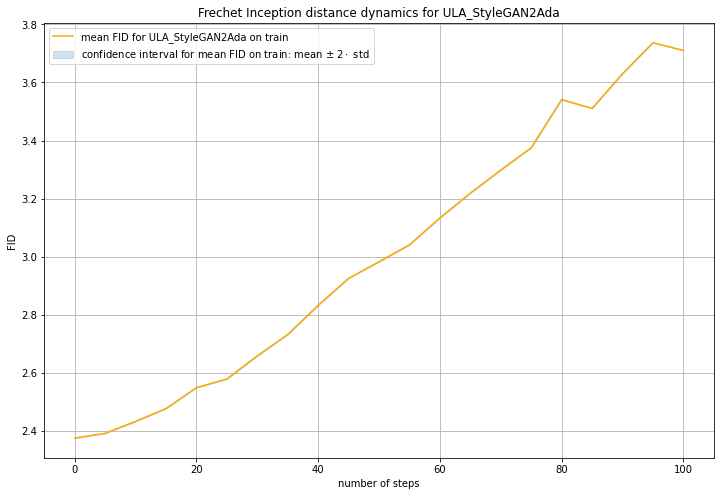

In [24]:
method_name = 'ULA_StyleGAN2Ada'
figsize = (12, 8)
path_to_figs = '/home/daniil/gans-mcmc/gans_sampling/figs'
grad_step = 0.01
eps_scale = 0.1
every_step = 5

plot_scores_cifar10_dynamics(dict_results,
                                 every_step, method_name,
                                 figsize,
                                 path_to_figs,
                                 grad_step,
                                 eps_scale,
                                 coef = 2.0,
                                 plot_is = False,
                                 plot_fid_train = True,
                                 plot_fid_test = False)

# SIR

In [6]:
loc = torch.zeros(G.z_dim).to(device)
scale = torch.ones(G.z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

In [7]:
log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy_stylegan2_ada,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 32
n = 50000
n_steps = 100
N = 2
method_name = 'sir_stylegan2_ada'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_N_{N}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = sir_independent_dynamics_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, N)


  0%|          | 0/1563 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


  0%|          | 1/1563 [00:11<4:52:08, 11.22s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_0.npy was saved, file shape = (21, 32, 512)


  0%|          | 2/1563 [00:21<4:46:07, 11.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32.npy was saved, file shape = (21, 32, 512)


  0%|          | 3/1563 [00:32<4:42:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_64.npy was saved, file shape = (21, 32, 512)


  0%|          | 4/1563 [00:42<4:39:55, 10.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_96.npy was saved, file shape = (21, 32, 512)


  0%|          | 5/1563 [00:53<4:38:30, 10.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_128.npy was saved, file shape = (21, 32, 512)


  0%|          | 6/1563 [01:04<4:37:44, 10.70s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_160.npy was saved, file shape = (21, 32, 512)


  0%|          | 7/1563 [01:14<4:37:30, 10.70s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_192.npy was saved, file shape = (21, 32, 512)


  1%|          | 8/1563 [01:25<4:37:27, 10.71s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_224.npy was saved, file shape = (21, 32, 512)


  1%|          | 9/1563 [01:36<4:37:34, 10.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_256.npy was saved, file shape = (21, 32, 512)


  1%|          | 10/1563 [01:46<4:37:44, 10.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_288.npy was saved, file shape = (21, 32, 512)


  1%|          | 11/1563 [01:57<4:37:55, 10.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_320.npy was saved, file shape = (21, 32, 512)


  1%|          | 12/1563 [02:08<4:38:03, 10.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_352.npy was saved, file shape = (21, 32, 512)


  1%|          | 13/1563 [02:19<4:38:11, 10.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_384.npy was saved, file shape = (21, 32, 512)


  1%|          | 14/1563 [02:30<4:38:18, 10.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_416.npy was saved, file shape = (21, 32, 512)


  1%|          | 15/1563 [02:41<4:38:42, 10.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_448.npy was saved, file shape = (21, 32, 512)


  1%|          | 16/1563 [02:51<4:39:19, 10.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_480.npy was saved, file shape = (21, 32, 512)


  1%|          | 17/1563 [03:02<4:39:48, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_512.npy was saved, file shape = (21, 32, 512)


  1%|          | 18/1563 [03:13<4:40:09, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_544.npy was saved, file shape = (21, 32, 512)


  1%|          | 19/1563 [03:24<4:40:27, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_576.npy was saved, file shape = (21, 32, 512)


  1%|▏         | 20/1563 [03:35<4:40:37, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_608.npy was saved, file shape = (21, 32, 512)


  1%|▏         | 21/1563 [03:46<4:40:48, 10.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_640.npy was saved, file shape = (21, 32, 512)


  1%|▏         | 22/1563 [03:57<4:40:42, 10.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_672.npy was saved, file shape = (21, 32, 512)


  1%|▏         | 23/1563 [04:08<4:40:44, 10.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_704.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 24/1563 [04:19<4:40:40, 10.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_736.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 25/1563 [04:30<4:40:40, 10.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_768.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 26/1563 [04:41<4:40:40, 10.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_800.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 27/1563 [04:52<4:40:27, 10.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_832.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 28/1563 [05:03<4:40:21, 10.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_864.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 29/1563 [05:14<4:40:13, 10.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_896.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 30/1563 [05:25<4:39:59, 10.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_928.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 31/1563 [05:36<4:39:42, 10.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_960.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 32/1563 [05:47<4:39:21, 10.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_992.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 33/1563 [05:58<4:39:11, 10.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1024.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 34/1563 [06:08<4:38:54, 10.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1056.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 35/1563 [06:19<4:38:42, 10.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1088.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 36/1563 [06:30<4:38:29, 10.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1120.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 37/1563 [06:41<4:38:12, 10.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1152.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 38/1563 [06:52<4:37:46, 10.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1184.npy was saved, file shape = (21, 32, 512)


  2%|▏         | 39/1563 [07:03<4:37:31, 10.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1216.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 40/1563 [07:14<4:37:10, 10.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1248.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 41/1563 [07:25<4:36:57, 10.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1280.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 42/1563 [07:36<4:36:47, 10.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1312.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 43/1563 [07:47<4:36:28, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1344.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 44/1563 [07:58<4:36:10, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1376.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 45/1563 [08:09<4:35:54, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1408.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 46/1563 [08:19<4:35:35, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1440.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 47/1563 [08:30<4:35:28, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1472.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 48/1563 [08:41<4:35:24, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1504.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 49/1563 [08:52<4:35:03, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1536.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 50/1563 [09:03<4:34:50, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1568.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 51/1563 [09:14<4:34:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1600.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 52/1563 [09:25<4:34:35, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1632.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 53/1563 [09:36<4:34:22, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1664.npy was saved, file shape = (21, 32, 512)


  3%|▎         | 54/1563 [09:47<4:34:11, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1696.npy was saved, file shape = (21, 32, 512)


  4%|▎         | 55/1563 [09:58<4:34:00, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1728.npy was saved, file shape = (21, 32, 512)


  4%|▎         | 56/1563 [10:09<4:34:04, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1760.npy was saved, file shape = (21, 32, 512)


  4%|▎         | 57/1563 [10:19<4:33:50, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1792.npy was saved, file shape = (21, 32, 512)


  4%|▎         | 58/1563 [10:30<4:33:35, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1824.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 59/1563 [10:41<4:33:30, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1856.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 60/1563 [10:52<4:33:16, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1888.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 61/1563 [11:03<4:33:04, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1920.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 62/1563 [11:14<4:32:48, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1952.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 63/1563 [11:25<4:32:41, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_1984.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 64/1563 [11:36<4:32:29, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2016.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 65/1563 [11:47<4:32:26, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2048.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 66/1563 [11:58<4:32:06, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2080.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 67/1563 [12:09<4:31:57, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2112.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 68/1563 [12:19<4:31:47, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2144.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 69/1563 [12:30<4:31:43, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2176.npy was saved, file shape = (21, 32, 512)


  4%|▍         | 70/1563 [12:41<4:31:23, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2208.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 71/1563 [12:52<4:31:21, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2240.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 72/1563 [13:03<4:31:06, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2272.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 73/1563 [13:14<4:30:52, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2304.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 74/1563 [13:25<4:30:38, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2336.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 75/1563 [13:36<4:30:28, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2368.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 76/1563 [13:47<4:30:19, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2400.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 77/1563 [13:58<4:30:02, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2432.npy was saved, file shape = (21, 32, 512)


  5%|▍         | 78/1563 [14:08<4:29:46, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2464.npy was saved, file shape = (21, 32, 512)


  5%|▌         | 79/1563 [14:19<4:29:46, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2496.npy was saved, file shape = (21, 32, 512)


  5%|▌         | 80/1563 [14:30<4:29:28, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2528.npy was saved, file shape = (21, 32, 512)


  5%|▌         | 81/1563 [14:41<4:29:13, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2560.npy was saved, file shape = (21, 32, 512)


  5%|▌         | 82/1563 [14:52<4:29:06, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2592.npy was saved, file shape = (21, 32, 512)


  5%|▌         | 83/1563 [15:03<4:28:52, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2624.npy was saved, file shape = (21, 32, 512)


  5%|▌         | 84/1563 [15:14<4:28:47, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2656.npy was saved, file shape = (21, 32, 512)


  5%|▌         | 85/1563 [15:25<4:28:41, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2688.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 86/1563 [15:36<4:28:29, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2720.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 87/1563 [15:47<4:28:13, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2752.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 88/1563 [15:58<4:28:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2784.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 89/1563 [16:08<4:27:50, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2816.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 90/1563 [16:19<4:27:39, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2848.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 91/1563 [16:30<4:27:24, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2880.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 92/1563 [16:41<4:27:20, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2912.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 93/1563 [16:52<4:27:07, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2944.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 94/1563 [17:03<4:26:52, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_2976.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 95/1563 [17:14<4:26:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3008.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 96/1563 [17:25<4:26:25, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3040.npy was saved, file shape = (21, 32, 512)


  6%|▌         | 97/1563 [17:36<4:26:14, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3072.npy was saved, file shape = (21, 32, 512)


  6%|▋         | 98/1563 [17:47<4:26:07, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3104.npy was saved, file shape = (21, 32, 512)


  6%|▋         | 99/1563 [17:57<4:25:51, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3136.npy was saved, file shape = (21, 32, 512)


  6%|▋         | 100/1563 [18:08<4:25:43, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3168.npy was saved, file shape = (21, 32, 512)


  6%|▋         | 101/1563 [18:19<4:25:31, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3200.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 102/1563 [18:30<4:25:19, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3232.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 103/1563 [18:41<4:25:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3264.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 104/1563 [18:52<4:24:59, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3296.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 105/1563 [19:03<4:24:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3328.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 106/1563 [19:14<4:24:33, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3360.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 107/1563 [19:25<4:24:31, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3392.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 108/1563 [19:35<4:24:16, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3424.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 109/1563 [19:46<4:24:01, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3456.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 110/1563 [19:57<4:23:56, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3488.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 111/1563 [20:08<4:23:47, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3520.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 112/1563 [20:19<4:23:29, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3552.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 113/1563 [20:30<4:23:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3584.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 114/1563 [20:41<4:23:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3616.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 115/1563 [20:52<4:22:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3648.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 116/1563 [21:03<4:22:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3680.npy was saved, file shape = (21, 32, 512)


  7%|▋         | 117/1563 [21:14<4:22:29, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3712.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 118/1563 [21:24<4:22:10, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3744.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 119/1563 [21:35<4:22:01, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3776.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 120/1563 [21:46<4:21:42, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3808.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 121/1563 [21:57<4:21:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3840.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 122/1563 [22:08<4:21:22, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3872.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 123/1563 [22:19<4:21:12, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3904.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 124/1563 [22:30<4:20:56, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3936.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 125/1563 [22:41<4:20:43, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_3968.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 126/1563 [22:51<4:20:30, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4000.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 127/1563 [23:02<4:20:18, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4032.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 128/1563 [23:13<4:20:05, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4064.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 129/1563 [23:24<4:20:01, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4096.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 130/1563 [23:35<4:19:51, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4128.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 131/1563 [23:46<4:19:33, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4160.npy was saved, file shape = (21, 32, 512)


  8%|▊         | 132/1563 [23:57<4:19:17, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4192.npy was saved, file shape = (21, 32, 512)


  9%|▊         | 133/1563 [24:08<4:19:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4224.npy was saved, file shape = (21, 32, 512)


  9%|▊         | 134/1563 [24:18<4:18:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4256.npy was saved, file shape = (21, 32, 512)


  9%|▊         | 135/1563 [24:29<4:18:47, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4288.npy was saved, file shape = (21, 32, 512)


  9%|▊         | 136/1563 [24:40<4:18:34, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4320.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 137/1563 [24:51<4:18:15, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4352.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 138/1563 [25:02<4:18:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4384.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 139/1563 [25:13<4:17:54, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4416.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 140/1563 [25:24<4:17:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4448.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 141/1563 [25:34<4:17:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4480.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 142/1563 [25:45<4:17:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4512.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 143/1563 [25:56<4:17:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4544.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 144/1563 [26:07<4:16:56, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4576.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 145/1563 [26:18<4:16:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4608.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 146/1563 [26:29<4:16:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4640.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 147/1563 [26:40<4:16:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4672.npy was saved, file shape = (21, 32, 512)


  9%|▉         | 148/1563 [26:51<4:16:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4704.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 149/1563 [27:01<4:16:00, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4736.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 150/1563 [27:12<4:15:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4768.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 151/1563 [27:23<4:15:50, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4800.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 152/1563 [27:34<4:15:36, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4832.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 153/1563 [27:45<4:15:35, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4864.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 154/1563 [27:56<4:15:21, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4896.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 155/1563 [28:07<4:15:12, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4928.npy was saved, file shape = (21, 32, 512)


 10%|▉         | 156/1563 [28:18<4:15:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4960.npy was saved, file shape = (21, 32, 512)


 10%|█         | 157/1563 [28:28<4:14:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_4992.npy was saved, file shape = (21, 32, 512)


 10%|█         | 158/1563 [28:39<4:14:36, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5024.npy was saved, file shape = (21, 32, 512)


 10%|█         | 159/1563 [28:50<4:14:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5056.npy was saved, file shape = (21, 32, 512)


 10%|█         | 160/1563 [29:01<4:14:06, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5088.npy was saved, file shape = (21, 32, 512)


 10%|█         | 161/1563 [29:12<4:14:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5120.npy was saved, file shape = (21, 32, 512)


 10%|█         | 162/1563 [29:23<4:13:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5152.npy was saved, file shape = (21, 32, 512)


 10%|█         | 163/1563 [29:34<4:13:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5184.npy was saved, file shape = (21, 32, 512)


 10%|█         | 164/1563 [29:44<4:13:28, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5216.npy was saved, file shape = (21, 32, 512)


 11%|█         | 165/1563 [29:55<4:13:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5248.npy was saved, file shape = (21, 32, 512)


 11%|█         | 166/1563 [30:06<4:13:08, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5280.npy was saved, file shape = (21, 32, 512)


 11%|█         | 167/1563 [30:17<4:12:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5312.npy was saved, file shape = (21, 32, 512)


 11%|█         | 168/1563 [30:28<4:12:44, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5344.npy was saved, file shape = (21, 32, 512)


 11%|█         | 169/1563 [30:39<4:12:37, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5376.npy was saved, file shape = (21, 32, 512)


 11%|█         | 170/1563 [30:50<4:12:22, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5408.npy was saved, file shape = (21, 32, 512)


 11%|█         | 171/1563 [31:01<4:12:19, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5440.npy was saved, file shape = (21, 32, 512)


 11%|█         | 172/1563 [31:11<4:12:09, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5472.npy was saved, file shape = (21, 32, 512)


 11%|█         | 173/1563 [31:22<4:12:01, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5504.npy was saved, file shape = (21, 32, 512)


 11%|█         | 174/1563 [31:33<4:11:49, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5536.npy was saved, file shape = (21, 32, 512)


 11%|█         | 175/1563 [31:44<4:11:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5568.npy was saved, file shape = (21, 32, 512)


 11%|█▏        | 176/1563 [31:55<4:11:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5600.npy was saved, file shape = (21, 32, 512)


 11%|█▏        | 177/1563 [32:06<4:11:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5632.npy was saved, file shape = (21, 32, 512)


 11%|█▏        | 178/1563 [32:17<4:10:58, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5664.npy was saved, file shape = (21, 32, 512)


 11%|█▏        | 179/1563 [32:28<4:10:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5696.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 180/1563 [32:38<4:10:42, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5728.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 181/1563 [32:49<4:10:39, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5760.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 182/1563 [33:00<4:10:28, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5792.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 183/1563 [33:11<4:10:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5824.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 184/1563 [33:22<4:10:13, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5856.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 185/1563 [33:33<4:10:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5888.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 186/1563 [33:44<4:10:00, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5920.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 187/1563 [33:55<4:09:54, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5952.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 188/1563 [34:06<4:09:36, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_5984.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 189/1563 [34:17<4:09:25, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6016.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 190/1563 [34:27<4:09:21, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6048.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 191/1563 [34:38<4:09:12, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6080.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 192/1563 [34:49<4:08:57, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6112.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 193/1563 [35:00<4:08:54, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6144.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 194/1563 [35:11<4:08:50, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6176.npy was saved, file shape = (21, 32, 512)


 12%|█▏        | 195/1563 [35:22<4:08:34, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6208.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 196/1563 [35:33<4:08:21, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6240.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 197/1563 [35:44<4:08:11, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6272.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 198/1563 [35:55<4:08:02, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6304.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 199/1563 [36:06<4:07:52, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6336.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 200/1563 [36:16<4:07:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6368.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 201/1563 [36:27<4:07:27, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6400.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 202/1563 [36:38<4:07:18, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6432.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 203/1563 [36:49<4:07:09, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6464.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 204/1563 [37:00<4:06:55, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6496.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 205/1563 [37:11<4:06:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6528.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 206/1563 [37:22<4:06:29, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6560.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 207/1563 [37:33<4:06:18, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6592.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 208/1563 [37:44<4:06:02, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6624.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 209/1563 [37:55<4:05:53, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6656.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 210/1563 [38:05<4:05:46, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6688.npy was saved, file shape = (21, 32, 512)


 13%|█▎        | 211/1563 [38:16<4:05:30, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6720.npy was saved, file shape = (21, 32, 512)


 14%|█▎        | 212/1563 [38:27<4:05:21, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6752.npy was saved, file shape = (21, 32, 512)


 14%|█▎        | 213/1563 [38:38<4:05:09, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6784.npy was saved, file shape = (21, 32, 512)


 14%|█▎        | 214/1563 [38:49<4:05:01, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6816.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 215/1563 [39:00<4:04:47, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6848.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 216/1563 [39:11<4:04:45, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6880.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 217/1563 [39:22<4:04:34, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6912.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 218/1563 [39:33<4:04:18, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6944.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 219/1563 [39:44<4:04:09, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_6976.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 220/1563 [39:54<4:03:56, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7008.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 221/1563 [40:05<4:03:44, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7040.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 222/1563 [40:16<4:03:31, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7072.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 223/1563 [40:27<4:03:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7104.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 224/1563 [40:38<4:03:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7136.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 225/1563 [40:49<4:02:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7168.npy was saved, file shape = (21, 32, 512)


 14%|█▍        | 226/1563 [41:00<4:02:49, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7200.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 227/1563 [41:11<4:02:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7232.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 228/1563 [41:22<4:02:20, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7264.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 229/1563 [41:32<4:02:16, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7296.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 230/1563 [41:43<4:02:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7328.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 231/1563 [41:54<4:01:50, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7360.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 232/1563 [42:05<4:01:36, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7392.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 233/1563 [42:16<4:01:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7424.npy was saved, file shape = (21, 32, 512)


 15%|█▍        | 234/1563 [42:27<4:01:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7456.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 235/1563 [42:38<4:01:08, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7488.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 236/1563 [42:49<4:00:50, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7520.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 237/1563 [43:00<4:00:40, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7552.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 238/1563 [43:10<4:00:27, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7584.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 239/1563 [43:21<4:00:20, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7616.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 240/1563 [43:32<4:00:06, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7648.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 241/1563 [43:43<3:59:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7680.npy was saved, file shape = (21, 32, 512)


 15%|█▌        | 242/1563 [43:54<3:59:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7712.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 243/1563 [44:05<3:59:31, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7744.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 244/1563 [44:16<3:59:18, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7776.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 245/1563 [44:27<3:59:06, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7808.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 246/1563 [44:38<3:58:49, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7840.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 247/1563 [44:48<3:58:34, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7872.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 248/1563 [44:59<3:58:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7904.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 249/1563 [45:10<3:58:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7936.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 250/1563 [45:21<3:57:52, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_7968.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 251/1563 [45:32<3:57:51, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8000.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 252/1563 [45:43<3:57:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8032.npy was saved, file shape = (21, 32, 512)


 16%|█▌        | 253/1563 [45:54<3:57:21, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8064.npy was saved, file shape = (21, 32, 512)


 16%|█▋        | 254/1563 [46:05<3:57:06, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8096.npy was saved, file shape = (21, 32, 512)


 16%|█▋        | 255/1563 [46:15<3:56:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8128.npy was saved, file shape = (21, 32, 512)


 16%|█▋        | 256/1563 [46:26<3:56:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8160.npy was saved, file shape = (21, 32, 512)


 16%|█▋        | 257/1563 [46:37<3:56:44, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8192.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 258/1563 [46:48<3:56:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8224.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 259/1563 [46:59<3:56:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8256.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 260/1563 [47:10<3:56:02, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8288.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 261/1563 [47:21<3:55:50, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8320.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 262/1563 [47:31<3:55:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8352.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 263/1563 [47:42<3:55:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8384.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 264/1563 [47:53<3:55:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8416.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 265/1563 [48:04<3:55:06, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8448.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 266/1563 [48:15<3:54:58, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8480.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 267/1563 [48:26<3:54:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8512.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 268/1563 [48:37<3:54:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8544.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 269/1563 [48:48<3:54:28, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8576.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 270/1563 [48:58<3:54:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8608.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 271/1563 [49:09<3:54:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8640.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 272/1563 [49:20<3:53:47, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8672.npy was saved, file shape = (21, 32, 512)


 17%|█▋        | 273/1563 [49:31<3:53:38, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8704.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 274/1563 [49:42<3:53:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8736.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 275/1563 [49:53<3:53:22, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8768.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 276/1563 [50:04<3:53:04, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8800.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 277/1563 [50:15<3:53:01, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8832.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 278/1563 [50:25<3:52:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8864.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 279/1563 [50:36<3:52:36, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8896.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 280/1563 [50:47<3:52:26, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8928.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 281/1563 [50:58<3:52:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8960.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 282/1563 [51:09<3:52:03, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_8992.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 283/1563 [51:20<3:51:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9024.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 284/1563 [51:31<3:51:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9056.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 285/1563 [51:41<3:51:36, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9088.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 286/1563 [51:52<3:51:21, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9120.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 287/1563 [52:03<3:51:08, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9152.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 288/1563 [52:14<3:50:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9184.npy was saved, file shape = (21, 32, 512)


 18%|█▊        | 289/1563 [52:25<3:50:41, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9216.npy was saved, file shape = (21, 32, 512)


 19%|█▊        | 290/1563 [52:36<3:50:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9248.npy was saved, file shape = (21, 32, 512)


 19%|█▊        | 291/1563 [52:47<3:50:38, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9280.npy was saved, file shape = (21, 32, 512)


 19%|█▊        | 292/1563 [52:58<3:50:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9312.npy was saved, file shape = (21, 32, 512)


 19%|█▊        | 293/1563 [53:08<3:50:03, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9344.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 294/1563 [53:19<3:49:55, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9376.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 295/1563 [53:30<3:49:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9408.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 296/1563 [53:41<3:49:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9440.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 297/1563 [53:52<3:49:17, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9472.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 298/1563 [54:03<3:49:03, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9504.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 299/1563 [54:14<3:49:02, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9536.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 300/1563 [54:25<3:48:47, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9568.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 301/1563 [54:35<3:48:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9600.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 302/1563 [54:46<3:48:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9632.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 303/1563 [54:57<3:48:30, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9664.npy was saved, file shape = (21, 32, 512)


 19%|█▉        | 304/1563 [55:08<3:48:23, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9696.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 305/1563 [55:19<3:48:15, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9728.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 306/1563 [55:30<3:48:08, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9760.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 307/1563 [55:41<3:47:55, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9792.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 308/1563 [55:52<3:47:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9824.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 309/1563 [56:03<3:47:42, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9856.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 310/1563 [56:13<3:47:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9888.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 311/1563 [56:24<3:47:21, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9920.npy was saved, file shape = (21, 32, 512)


 20%|█▉        | 312/1563 [56:35<3:47:10, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9952.npy was saved, file shape = (21, 32, 512)


 20%|██        | 313/1563 [56:46<3:47:05, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_9984.npy was saved, file shape = (21, 32, 512)


 20%|██        | 314/1563 [56:57<3:46:53, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10016.npy was saved, file shape = (21, 32, 512)


 20%|██        | 315/1563 [57:08<3:46:40, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10048.npy was saved, file shape = (21, 32, 512)


 20%|██        | 316/1563 [57:19<3:46:26, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10080.npy was saved, file shape = (21, 32, 512)


 20%|██        | 317/1563 [57:30<3:46:15, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10112.npy was saved, file shape = (21, 32, 512)


 20%|██        | 318/1563 [57:41<3:46:12, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10144.npy was saved, file shape = (21, 32, 512)


 20%|██        | 319/1563 [57:52<3:46:01, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10176.npy was saved, file shape = (21, 32, 512)


 20%|██        | 320/1563 [58:02<3:45:46, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10208.npy was saved, file shape = (21, 32, 512)


 21%|██        | 321/1563 [58:13<3:45:37, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10240.npy was saved, file shape = (21, 32, 512)


 21%|██        | 322/1563 [58:24<3:45:23, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10272.npy was saved, file shape = (21, 32, 512)


 21%|██        | 323/1563 [58:35<3:45:13, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10304.npy was saved, file shape = (21, 32, 512)


 21%|██        | 324/1563 [58:46<3:45:01, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10336.npy was saved, file shape = (21, 32, 512)


 21%|██        | 325/1563 [58:57<3:44:54, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10368.npy was saved, file shape = (21, 32, 512)


 21%|██        | 326/1563 [59:08<3:44:47, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10400.npy was saved, file shape = (21, 32, 512)


 21%|██        | 327/1563 [59:19<3:44:35, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10432.npy was saved, file shape = (21, 32, 512)


 21%|██        | 328/1563 [59:30<3:44:20, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10464.npy was saved, file shape = (21, 32, 512)


 21%|██        | 329/1563 [59:41<3:44:09, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10496.npy was saved, file shape = (21, 32, 512)


 21%|██        | 330/1563 [59:51<3:43:59, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10528.npy was saved, file shape = (21, 32, 512)


 21%|██        | 331/1563 [1:00:02<3:43:49, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10560.npy was saved, file shape = (21, 32, 512)


 21%|██        | 332/1563 [1:00:13<3:43:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10592.npy was saved, file shape = (21, 32, 512)


 21%|██▏       | 333/1563 [1:00:24<3:43:26, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10624.npy was saved, file shape = (21, 32, 512)


 21%|██▏       | 334/1563 [1:00:35<3:43:17, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10656.npy was saved, file shape = (21, 32, 512)


 21%|██▏       | 335/1563 [1:00:46<3:43:03, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10688.npy was saved, file shape = (21, 32, 512)


 21%|██▏       | 336/1563 [1:00:57<3:42:52, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10720.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 337/1563 [1:01:08<3:42:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10752.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 338/1563 [1:01:19<3:42:32, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10784.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 339/1563 [1:01:30<3:42:17, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10816.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 340/1563 [1:01:40<3:42:08, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10848.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 341/1563 [1:01:51<3:41:54, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10880.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 342/1563 [1:02:02<3:41:45, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10912.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 343/1563 [1:02:13<3:41:36, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10944.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 344/1563 [1:02:24<3:41:23, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_10976.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 345/1563 [1:02:35<3:41:07, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11008.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 346/1563 [1:02:46<3:40:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11040.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 347/1563 [1:02:57<3:40:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11072.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 348/1563 [1:03:08<3:40:31, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11104.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 349/1563 [1:03:18<3:40:22, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11136.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 350/1563 [1:03:29<3:40:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11168.npy was saved, file shape = (21, 32, 512)


 22%|██▏       | 351/1563 [1:03:40<3:39:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11200.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 352/1563 [1:03:51<3:39:45, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11232.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 353/1563 [1:04:02<3:39:30, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11264.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 354/1563 [1:04:13<3:39:25, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11296.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 355/1563 [1:04:24<3:39:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11328.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 356/1563 [1:04:35<3:38:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11360.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 357/1563 [1:04:46<3:38:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11392.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 358/1563 [1:04:56<3:38:34, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11424.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 359/1563 [1:05:07<3:38:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11456.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 360/1563 [1:05:18<3:38:16, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11488.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 361/1563 [1:05:29<3:38:08, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11520.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 362/1563 [1:05:40<3:37:56, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11552.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 363/1563 [1:05:51<3:37:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11584.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 364/1563 [1:06:02<3:37:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11616.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 365/1563 [1:06:13<3:37:09, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11648.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 366/1563 [1:06:23<3:37:01, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11680.npy was saved, file shape = (21, 32, 512)


 23%|██▎       | 367/1563 [1:06:34<3:36:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11712.npy was saved, file shape = (21, 32, 512)


 24%|██▎       | 368/1563 [1:06:45<3:36:33, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11744.npy was saved, file shape = (21, 32, 512)


 24%|██▎       | 369/1563 [1:06:56<3:36:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11776.npy was saved, file shape = (21, 32, 512)


 24%|██▎       | 370/1563 [1:07:07<3:36:02, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11808.npy was saved, file shape = (21, 32, 512)


 24%|██▎       | 371/1563 [1:07:18<3:35:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11840.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 372/1563 [1:07:29<3:35:44, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11872.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 373/1563 [1:07:40<3:35:34, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11904.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 374/1563 [1:07:50<3:35:17, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11936.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 375/1563 [1:08:01<3:35:05, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_11968.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 376/1563 [1:08:12<3:34:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12000.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 377/1563 [1:08:23<3:34:43, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12032.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 378/1563 [1:08:34<3:34:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12064.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 379/1563 [1:08:45<3:34:23, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12096.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 380/1563 [1:08:56<3:34:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12128.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 381/1563 [1:09:06<3:34:00, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12160.npy was saved, file shape = (21, 32, 512)


 24%|██▍       | 382/1563 [1:09:17<3:33:46, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12192.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 383/1563 [1:09:28<3:33:38, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12224.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 384/1563 [1:09:39<3:33:27, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12256.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 385/1563 [1:09:50<3:33:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12288.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 386/1563 [1:10:01<3:33:06, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12320.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 387/1563 [1:10:12<3:32:54, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12352.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 388/1563 [1:10:22<3:32:43, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12384.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 389/1563 [1:10:33<3:32:35, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12416.npy was saved, file shape = (21, 32, 512)


 25%|██▍       | 390/1563 [1:10:44<3:32:29, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12448.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 391/1563 [1:10:55<3:32:12, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12480.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 392/1563 [1:11:06<3:32:02, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12512.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 393/1563 [1:11:17<3:31:54, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12544.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 394/1563 [1:11:28<3:31:38, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12576.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 395/1563 [1:11:39<3:31:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12608.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 396/1563 [1:11:49<3:31:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12640.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 397/1563 [1:12:00<3:31:10, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12672.npy was saved, file shape = (21, 32, 512)


 25%|██▌       | 398/1563 [1:12:11<3:30:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12704.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 399/1563 [1:12:22<3:30:42, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12736.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 400/1563 [1:12:33<3:30:31, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12768.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 401/1563 [1:12:44<3:30:27, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12800.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 402/1563 [1:12:55<3:30:14, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12832.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 403/1563 [1:13:05<3:30:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12864.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 404/1563 [1:13:16<3:29:52, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12896.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 405/1563 [1:13:27<3:29:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12928.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 406/1563 [1:13:38<3:29:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12960.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 407/1563 [1:13:49<3:29:22, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_12992.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 408/1563 [1:14:00<3:29:08, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13024.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 409/1563 [1:14:11<3:29:01, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13056.npy was saved, file shape = (21, 32, 512)


 26%|██▌       | 410/1563 [1:14:22<3:28:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13088.npy was saved, file shape = (21, 32, 512)


 26%|██▋       | 411/1563 [1:14:32<3:28:35, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13120.npy was saved, file shape = (21, 32, 512)


 26%|██▋       | 412/1563 [1:14:43<3:28:27, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13152.npy was saved, file shape = (21, 32, 512)


 26%|██▋       | 413/1563 [1:14:54<3:28:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13184.npy was saved, file shape = (21, 32, 512)


 26%|██▋       | 414/1563 [1:15:05<3:28:03, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13216.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 415/1563 [1:15:16<3:27:55, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13248.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 416/1563 [1:15:27<3:27:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13280.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 417/1563 [1:15:38<3:27:40, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13312.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 418/1563 [1:15:48<3:27:28, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13344.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 419/1563 [1:15:59<3:27:14, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13376.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 420/1563 [1:16:10<3:27:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13408.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 421/1563 [1:16:21<3:26:52, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13440.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 422/1563 [1:16:32<3:26:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13472.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 423/1563 [1:16:43<3:26:33, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13504.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 424/1563 [1:16:54<3:26:23, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13536.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 425/1563 [1:17:05<3:26:15, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13568.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 426/1563 [1:17:15<3:26:11, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13600.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 427/1563 [1:17:26<3:26:00, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13632.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 428/1563 [1:17:37<3:25:56, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13664.npy was saved, file shape = (21, 32, 512)


 27%|██▋       | 429/1563 [1:17:48<3:25:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13696.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 430/1563 [1:17:59<3:25:40, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13728.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 431/1563 [1:18:10<3:25:35, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13760.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 432/1563 [1:18:21<3:25:30, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13792.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 433/1563 [1:18:32<3:25:16, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13824.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 434/1563 [1:18:43<3:25:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13856.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 435/1563 [1:18:54<3:24:49, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13888.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 436/1563 [1:19:04<3:24:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13920.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 437/1563 [1:19:15<3:24:32, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13952.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 438/1563 [1:19:26<3:24:20, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_13984.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 439/1563 [1:19:37<3:24:09, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14016.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 440/1563 [1:19:48<3:23:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14048.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 441/1563 [1:19:59<3:23:44, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14080.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 442/1563 [1:20:10<3:23:33, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14112.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 443/1563 [1:20:21<3:23:23, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14144.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 444/1563 [1:20:32<3:23:17, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14176.npy was saved, file shape = (21, 32, 512)


 28%|██▊       | 445/1563 [1:20:43<3:23:05, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14208.npy was saved, file shape = (21, 32, 512)


 29%|██▊       | 446/1563 [1:20:53<3:22:53, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14240.npy was saved, file shape = (21, 32, 512)


 29%|██▊       | 447/1563 [1:21:04<3:22:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14272.npy was saved, file shape = (21, 32, 512)


 29%|██▊       | 448/1563 [1:21:15<3:22:29, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14304.npy was saved, file shape = (21, 32, 512)


 29%|██▊       | 449/1563 [1:21:26<3:22:21, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14336.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 450/1563 [1:21:37<3:22:07, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14368.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 451/1563 [1:21:48<3:22:01, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14400.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 452/1563 [1:21:59<3:21:47, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14432.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 453/1563 [1:22:10<3:21:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14464.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 454/1563 [1:22:21<3:21:27, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14496.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 455/1563 [1:22:32<3:21:19, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14528.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 456/1563 [1:22:42<3:21:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14560.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 457/1563 [1:22:53<3:20:51, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14592.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 458/1563 [1:23:04<3:20:40, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14624.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 459/1563 [1:23:15<3:20:28, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14656.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 460/1563 [1:23:26<3:20:18, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14688.npy was saved, file shape = (21, 32, 512)


 29%|██▉       | 461/1563 [1:23:37<3:20:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14720.npy was saved, file shape = (21, 32, 512)


 30%|██▉       | 462/1563 [1:23:48<3:19:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14752.npy was saved, file shape = (21, 32, 512)


 30%|██▉       | 463/1563 [1:23:59<3:19:42, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14784.npy was saved, file shape = (21, 32, 512)


 30%|██▉       | 464/1563 [1:24:10<3:19:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14816.npy was saved, file shape = (21, 32, 512)


 30%|██▉       | 465/1563 [1:24:20<3:19:19, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14848.npy was saved, file shape = (21, 32, 512)


 30%|██▉       | 466/1563 [1:24:31<3:19:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14880.npy was saved, file shape = (21, 32, 512)


 30%|██▉       | 467/1563 [1:24:42<3:18:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14912.npy was saved, file shape = (21, 32, 512)


 30%|██▉       | 468/1563 [1:24:53<3:18:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14944.npy was saved, file shape = (21, 32, 512)


 30%|███       | 469/1563 [1:25:04<3:18:36, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_14976.npy was saved, file shape = (21, 32, 512)


 30%|███       | 470/1563 [1:25:15<3:18:26, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15008.npy was saved, file shape = (21, 32, 512)


 30%|███       | 471/1563 [1:25:26<3:18:12, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15040.npy was saved, file shape = (21, 32, 512)


 30%|███       | 472/1563 [1:25:37<3:17:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15072.npy was saved, file shape = (21, 32, 512)


 30%|███       | 473/1563 [1:25:48<3:17:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15104.npy was saved, file shape = (21, 32, 512)


 30%|███       | 474/1563 [1:25:58<3:17:39, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15136.npy was saved, file shape = (21, 32, 512)


 30%|███       | 475/1563 [1:26:09<3:17:24, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15168.npy was saved, file shape = (21, 32, 512)


 30%|███       | 476/1563 [1:26:20<3:17:12, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15200.npy was saved, file shape = (21, 32, 512)


 31%|███       | 477/1563 [1:26:31<3:17:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15232.npy was saved, file shape = (21, 32, 512)


 31%|███       | 478/1563 [1:26:42<3:16:49, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15264.npy was saved, file shape = (21, 32, 512)


 31%|███       | 479/1563 [1:26:53<3:16:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15296.npy was saved, file shape = (21, 32, 512)


 31%|███       | 480/1563 [1:27:04<3:16:27, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15328.npy was saved, file shape = (21, 32, 512)


 31%|███       | 481/1563 [1:27:15<3:16:19, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15360.npy was saved, file shape = (21, 32, 512)


 31%|███       | 482/1563 [1:27:26<3:16:10, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15392.npy was saved, file shape = (21, 32, 512)


 31%|███       | 483/1563 [1:27:36<3:15:52, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15424.npy was saved, file shape = (21, 32, 512)


 31%|███       | 484/1563 [1:27:47<3:15:44, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15456.npy was saved, file shape = (21, 32, 512)


 31%|███       | 485/1563 [1:27:58<3:15:32, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15488.npy was saved, file shape = (21, 32, 512)


 31%|███       | 486/1563 [1:28:09<3:15:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15520.npy was saved, file shape = (21, 32, 512)


 31%|███       | 487/1563 [1:28:20<3:15:10, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15552.npy was saved, file shape = (21, 32, 512)


 31%|███       | 488/1563 [1:28:31<3:14:59, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15584.npy was saved, file shape = (21, 32, 512)


 31%|███▏      | 489/1563 [1:28:42<3:14:42, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15616.npy was saved, file shape = (21, 32, 512)


 31%|███▏      | 490/1563 [1:28:53<3:14:26, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15648.npy was saved, file shape = (21, 32, 512)


 31%|███▏      | 491/1563 [1:29:03<3:14:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15680.npy was saved, file shape = (21, 32, 512)


 31%|███▏      | 492/1563 [1:29:14<3:14:02, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15712.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 493/1563 [1:29:25<3:13:47, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15744.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 494/1563 [1:29:36<3:13:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15776.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 495/1563 [1:29:47<3:13:26, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15808.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 496/1563 [1:29:58<3:13:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15840.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 497/1563 [1:30:09<3:12:58, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15872.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 498/1563 [1:30:19<3:12:50, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15904.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 499/1563 [1:30:30<3:12:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15936.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 500/1563 [1:30:41<3:12:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_15968.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 501/1563 [1:30:52<3:12:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16000.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 502/1563 [1:31:03<3:12:05, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16032.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 503/1563 [1:31:14<3:11:49, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16064.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 504/1563 [1:31:25<3:11:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16096.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 505/1563 [1:31:36<3:11:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16128.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 506/1563 [1:31:46<3:11:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16160.npy was saved, file shape = (21, 32, 512)


 32%|███▏      | 507/1563 [1:31:57<3:11:10, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16192.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 508/1563 [1:32:08<3:11:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16224.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 509/1563 [1:32:19<3:10:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16256.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 510/1563 [1:32:30<3:10:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16288.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 511/1563 [1:32:41<3:10:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16320.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 512/1563 [1:32:52<3:10:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16352.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 513/1563 [1:33:02<3:10:05, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16384.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 514/1563 [1:33:13<3:09:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16416.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 515/1563 [1:33:24<3:09:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16448.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 516/1563 [1:33:35<3:09:27, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16480.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 517/1563 [1:33:46<3:09:17, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16512.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 518/1563 [1:33:57<3:09:09, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16544.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 519/1563 [1:34:08<3:09:00, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16576.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 520/1563 [1:34:18<3:08:46, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16608.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 521/1563 [1:34:29<3:08:34, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16640.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 522/1563 [1:34:40<3:08:23, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16672.npy was saved, file shape = (21, 32, 512)


 33%|███▎      | 523/1563 [1:34:51<3:08:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16704.npy was saved, file shape = (21, 32, 512)


 34%|███▎      | 524/1563 [1:35:02<3:08:04, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16736.npy was saved, file shape = (21, 32, 512)


 34%|███▎      | 525/1563 [1:35:13<3:08:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16768.npy was saved, file shape = (21, 32, 512)


 34%|███▎      | 526/1563 [1:35:24<3:07:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16800.npy was saved, file shape = (21, 32, 512)


 34%|███▎      | 527/1563 [1:35:34<3:07:35, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16832.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 528/1563 [1:35:45<3:07:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16864.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 529/1563 [1:35:56<3:07:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16896.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 530/1563 [1:36:07<3:07:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16928.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 531/1563 [1:36:18<3:06:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16960.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 532/1563 [1:36:29<3:06:44, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_16992.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 533/1563 [1:36:40<3:06:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17024.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 534/1563 [1:36:51<3:06:21, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17056.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 535/1563 [1:37:01<3:06:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17088.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 536/1563 [1:37:12<3:06:02, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17120.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 537/1563 [1:37:23<3:05:52, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17152.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 538/1563 [1:37:34<3:05:40, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17184.npy was saved, file shape = (21, 32, 512)


 34%|███▍      | 539/1563 [1:37:45<3:05:27, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17216.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 540/1563 [1:37:56<3:05:15, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17248.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 541/1563 [1:38:07<3:05:08, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17280.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 542/1563 [1:38:17<3:04:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17312.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 543/1563 [1:38:28<3:04:41, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17344.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 544/1563 [1:38:39<3:04:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17376.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 545/1563 [1:38:50<3:04:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17408.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 546/1563 [1:39:01<3:04:08, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17440.npy was saved, file shape = (21, 32, 512)


 35%|███▍      | 547/1563 [1:39:12<3:04:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17472.npy was saved, file shape = (21, 32, 512)


 35%|███▌      | 548/1563 [1:39:23<3:03:46, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17504.npy was saved, file shape = (21, 32, 512)


 35%|███▌      | 549/1563 [1:39:34<3:03:36, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17536.npy was saved, file shape = (21, 32, 512)


 35%|███▌      | 550/1563 [1:39:44<3:03:25, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17568.npy was saved, file shape = (21, 32, 512)


 35%|███▌      | 551/1563 [1:39:55<3:03:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17600.npy was saved, file shape = (21, 32, 512)


 35%|███▌      | 552/1563 [1:40:06<3:03:14, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17632.npy was saved, file shape = (21, 32, 512)


 35%|███▌      | 553/1563 [1:40:17<3:03:08, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17664.npy was saved, file shape = (21, 32, 512)


 35%|███▌      | 554/1563 [1:40:28<3:02:55, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17696.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 555/1563 [1:40:39<3:02:53, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17728.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 556/1563 [1:40:50<3:02:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17760.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 557/1563 [1:41:01<3:02:33, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17792.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 558/1563 [1:41:12<3:02:25, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17824.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 559/1563 [1:41:22<3:02:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17856.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 560/1563 [1:41:33<3:02:07, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17888.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 561/1563 [1:41:44<3:02:00, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17920.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 562/1563 [1:41:55<3:01:48, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17952.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 563/1563 [1:42:06<3:01:39, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_17984.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 564/1563 [1:42:17<3:01:26, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18016.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 565/1563 [1:42:28<3:01:17, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18048.npy was saved, file shape = (21, 32, 512)


 36%|███▌      | 566/1563 [1:42:39<3:01:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18080.npy was saved, file shape = (21, 32, 512)


 36%|███▋      | 567/1563 [1:42:50<3:00:56, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18112.npy was saved, file shape = (21, 32, 512)


 36%|███▋      | 568/1563 [1:43:01<3:00:42, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18144.npy was saved, file shape = (21, 32, 512)


 36%|███▋      | 569/1563 [1:43:11<3:00:32, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18176.npy was saved, file shape = (21, 32, 512)


 36%|███▋      | 570/1563 [1:43:22<3:00:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18208.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 571/1563 [1:43:33<3:00:10, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18240.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 572/1563 [1:43:44<2:59:56, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18272.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 573/1563 [1:43:55<2:59:42, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18304.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 574/1563 [1:44:06<2:59:36, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18336.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 575/1563 [1:44:17<2:59:24, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18368.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 576/1563 [1:44:28<2:59:17, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18400.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 577/1563 [1:44:39<2:59:06, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18432.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 578/1563 [1:44:49<2:58:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18464.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 579/1563 [1:45:00<2:58:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18496.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 580/1563 [1:45:11<2:58:27, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18528.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 581/1563 [1:45:22<2:58:18, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18560.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 582/1563 [1:45:33<2:58:07, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18592.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 583/1563 [1:45:44<2:57:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18624.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 584/1563 [1:45:55<2:57:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18656.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 585/1563 [1:46:06<2:57:27, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18688.npy was saved, file shape = (21, 32, 512)


 37%|███▋      | 586/1563 [1:46:17<2:57:20, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18720.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 587/1563 [1:46:27<2:57:14, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18752.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 588/1563 [1:46:38<2:56:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18784.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 589/1563 [1:46:49<2:56:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18816.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 590/1563 [1:47:00<2:56:35, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18848.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 591/1563 [1:47:11<2:56:26, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18880.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 592/1563 [1:47:22<2:56:18, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18912.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 593/1563 [1:47:33<2:56:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18944.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 594/1563 [1:47:44<2:55:51, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_18976.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 595/1563 [1:47:55<2:55:40, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19008.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 596/1563 [1:48:05<2:55:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19040.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 597/1563 [1:48:16<2:55:19, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19072.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 598/1563 [1:48:27<2:55:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19104.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 599/1563 [1:48:38<2:55:00, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19136.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 600/1563 [1:48:49<2:54:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19168.npy was saved, file shape = (21, 32, 512)


 38%|███▊      | 601/1563 [1:49:00<2:54:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19200.npy was saved, file shape = (21, 32, 512)


 39%|███▊      | 602/1563 [1:49:11<2:54:20, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19232.npy was saved, file shape = (21, 32, 512)


 39%|███▊      | 603/1563 [1:49:22<2:54:07, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19264.npy was saved, file shape = (21, 32, 512)


 39%|███▊      | 604/1563 [1:49:33<2:53:58, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19296.npy was saved, file shape = (21, 32, 512)


 39%|███▊      | 605/1563 [1:49:43<2:53:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19328.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 606/1563 [1:49:54<2:53:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19360.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 607/1563 [1:50:05<2:53:24, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19392.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 608/1563 [1:50:16<2:53:13, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19424.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 609/1563 [1:50:27<2:53:03, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19456.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 610/1563 [1:50:38<2:52:51, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19488.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 611/1563 [1:50:49<2:52:40, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19520.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 612/1563 [1:51:00<2:52:31, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19552.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 613/1563 [1:51:11<2:52:15, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19584.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 614/1563 [1:51:21<2:52:02, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19616.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 615/1563 [1:51:32<2:51:51, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19648.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 616/1563 [1:51:43<2:51:40, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19680.npy was saved, file shape = (21, 32, 512)


 39%|███▉      | 617/1563 [1:51:54<2:51:27, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19712.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 618/1563 [1:52:05<2:51:17, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19744.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 619/1563 [1:52:16<2:51:03, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19776.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 620/1563 [1:52:27<2:50:47, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19808.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 621/1563 [1:52:37<2:50:35, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19840.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 622/1563 [1:52:48<2:50:22, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19872.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 623/1563 [1:52:59<2:50:15, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19904.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 624/1563 [1:53:10<2:50:04, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19936.npy was saved, file shape = (21, 32, 512)


 40%|███▉      | 625/1563 [1:53:21<2:49:49, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_19968.npy was saved, file shape = (21, 32, 512)


 40%|████      | 626/1563 [1:53:32<2:49:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20000.npy was saved, file shape = (21, 32, 512)


 40%|████      | 627/1563 [1:53:43<2:49:38, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20032.npy was saved, file shape = (21, 32, 512)


 40%|████      | 628/1563 [1:53:54<2:49:24, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20064.npy was saved, file shape = (21, 32, 512)


 40%|████      | 629/1563 [1:54:04<2:49:12, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20096.npy was saved, file shape = (21, 32, 512)


 40%|████      | 630/1563 [1:54:15<2:48:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20128.npy was saved, file shape = (21, 32, 512)


 40%|████      | 631/1563 [1:54:26<2:48:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20160.npy was saved, file shape = (21, 32, 512)


 40%|████      | 632/1563 [1:54:37<2:48:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20192.npy was saved, file shape = (21, 32, 512)


 40%|████      | 633/1563 [1:54:48<2:48:24, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20224.npy was saved, file shape = (21, 32, 512)


 41%|████      | 634/1563 [1:54:59<2:48:12, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20256.npy was saved, file shape = (21, 32, 512)


 41%|████      | 635/1563 [1:55:10<2:47:59, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20288.npy was saved, file shape = (21, 32, 512)


 41%|████      | 636/1563 [1:55:20<2:47:55, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20320.npy was saved, file shape = (21, 32, 512)


 41%|████      | 637/1563 [1:55:31<2:47:43, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20352.npy was saved, file shape = (21, 32, 512)


 41%|████      | 638/1563 [1:55:42<2:47:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20384.npy was saved, file shape = (21, 32, 512)


 41%|████      | 639/1563 [1:55:53<2:47:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20416.npy was saved, file shape = (21, 32, 512)


 41%|████      | 640/1563 [1:56:04<2:47:08, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20448.npy was saved, file shape = (21, 32, 512)


 41%|████      | 641/1563 [1:56:15<2:46:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20480.npy was saved, file shape = (21, 32, 512)


 41%|████      | 642/1563 [1:56:26<2:46:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20512.npy was saved, file shape = (21, 32, 512)


 41%|████      | 643/1563 [1:56:37<2:46:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20544.npy was saved, file shape = (21, 32, 512)


 41%|████      | 644/1563 [1:56:47<2:46:23, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20576.npy was saved, file shape = (21, 32, 512)


 41%|████▏     | 645/1563 [1:56:58<2:46:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20608.npy was saved, file shape = (21, 32, 512)


 41%|████▏     | 646/1563 [1:57:09<2:46:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20640.npy was saved, file shape = (21, 32, 512)


 41%|████▏     | 647/1563 [1:57:20<2:45:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20672.npy was saved, file shape = (21, 32, 512)


 41%|████▏     | 648/1563 [1:57:31<2:45:43, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20704.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 649/1563 [1:57:42<2:45:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20736.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 650/1563 [1:57:53<2:45:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20768.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 651/1563 [1:58:03<2:45:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20800.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 652/1563 [1:58:14<2:45:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20832.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 653/1563 [1:58:25<2:44:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20864.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 654/1563 [1:58:36<2:44:38, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20896.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 655/1563 [1:58:47<2:44:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20928.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 656/1563 [1:58:58<2:44:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20960.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 657/1563 [1:59:09<2:44:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_20992.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 658/1563 [1:59:20<2:43:54, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21024.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 659/1563 [1:59:30<2:43:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21056.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 660/1563 [1:59:41<2:43:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21088.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 661/1563 [1:59:52<2:43:22, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21120.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 662/1563 [2:00:03<2:43:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21152.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 663/1563 [2:00:14<2:43:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21184.npy was saved, file shape = (21, 32, 512)


 42%|████▏     | 664/1563 [2:00:25<2:42:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21216.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 665/1563 [2:00:36<2:42:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21248.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 666/1563 [2:00:46<2:42:27, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21280.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 667/1563 [2:00:57<2:42:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21312.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 668/1563 [2:01:08<2:42:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21344.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 669/1563 [2:01:19<2:41:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21376.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 670/1563 [2:01:30<2:41:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21408.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 671/1563 [2:01:41<2:41:37, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21440.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 672/1563 [2:01:52<2:41:31, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21472.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 673/1563 [2:02:03<2:41:22, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21504.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 674/1563 [2:02:13<2:41:13, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21536.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 675/1563 [2:02:24<2:41:04, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21568.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 676/1563 [2:02:35<2:40:56, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21600.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 677/1563 [2:02:46<2:40:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21632.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 678/1563 [2:02:57<2:40:38, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21664.npy was saved, file shape = (21, 32, 512)


 43%|████▎     | 679/1563 [2:03:08<2:40:25, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21696.npy was saved, file shape = (21, 32, 512)


 44%|████▎     | 680/1563 [2:03:19<2:40:13, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21728.npy was saved, file shape = (21, 32, 512)


 44%|████▎     | 681/1563 [2:03:30<2:40:08, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21760.npy was saved, file shape = (21, 32, 512)


 44%|████▎     | 682/1563 [2:03:41<2:39:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21792.npy was saved, file shape = (21, 32, 512)


 44%|████▎     | 683/1563 [2:03:51<2:39:42, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21824.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 684/1563 [2:04:02<2:39:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21856.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 685/1563 [2:04:13<2:39:21, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21888.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 686/1563 [2:04:24<2:39:17, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21920.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 687/1563 [2:04:35<2:39:08, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21952.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 688/1563 [2:04:46<2:38:55, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_21984.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 689/1563 [2:04:57<2:38:42, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22016.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 690/1563 [2:05:08<2:38:29, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22048.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 691/1563 [2:05:19<2:38:21, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22080.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 692/1563 [2:05:30<2:38:12, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22112.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 693/1563 [2:05:40<2:38:01, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22144.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 694/1563 [2:05:51<2:37:50, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22176.npy was saved, file shape = (21, 32, 512)


 44%|████▍     | 695/1563 [2:06:02<2:37:37, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22208.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 696/1563 [2:06:13<2:37:27, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22240.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 697/1563 [2:06:24<2:37:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22272.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 698/1563 [2:06:35<2:37:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22304.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 699/1563 [2:06:46<2:36:59, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22336.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 700/1563 [2:06:57<2:36:40, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22368.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 701/1563 [2:07:08<2:36:34, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22400.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 702/1563 [2:07:19<2:36:20, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22432.npy was saved, file shape = (21, 32, 512)


 45%|████▍     | 703/1563 [2:07:29<2:36:11, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22464.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 704/1563 [2:07:40<2:35:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22496.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 705/1563 [2:07:51<2:35:42, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22528.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 706/1563 [2:08:02<2:35:35, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22560.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 707/1563 [2:08:13<2:35:27, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22592.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 708/1563 [2:08:24<2:35:12, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22624.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 709/1563 [2:08:35<2:35:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22656.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 710/1563 [2:08:46<2:34:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22688.npy was saved, file shape = (21, 32, 512)


 45%|████▌     | 711/1563 [2:08:57<2:34:44, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22720.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 712/1563 [2:09:07<2:34:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22752.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 713/1563 [2:09:18<2:34:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22784.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 714/1563 [2:09:29<2:34:07, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22816.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 715/1563 [2:09:40<2:33:55, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22848.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 716/1563 [2:09:51<2:33:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22880.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 717/1563 [2:10:02<2:33:33, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22912.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 718/1563 [2:10:13<2:33:20, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22944.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 719/1563 [2:10:24<2:33:06, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_22976.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 720/1563 [2:10:35<2:32:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23008.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 721/1563 [2:10:45<2:32:50, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23040.npy was saved, file shape = (21, 32, 512)


 46%|████▌     | 722/1563 [2:10:56<2:32:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23072.npy was saved, file shape = (21, 32, 512)


 46%|████▋     | 723/1563 [2:11:07<2:32:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23104.npy was saved, file shape = (21, 32, 512)


 46%|████▋     | 724/1563 [2:11:18<2:32:18, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23136.npy was saved, file shape = (21, 32, 512)


 46%|████▋     | 725/1563 [2:11:29<2:32:04, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23168.npy was saved, file shape = (21, 32, 512)


 46%|████▋     | 726/1563 [2:11:40<2:31:50, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23200.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 727/1563 [2:11:51<2:31:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23232.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 728/1563 [2:12:02<2:31:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23264.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 729/1563 [2:12:13<2:31:23, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23296.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 730/1563 [2:12:23<2:31:07, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23328.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 731/1563 [2:12:34<2:30:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23360.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 732/1563 [2:12:45<2:30:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23392.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 733/1563 [2:12:56<2:30:34, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23424.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 734/1563 [2:13:07<2:30:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23456.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 735/1563 [2:13:18<2:30:06, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23488.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 736/1563 [2:13:29<2:29:55, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23520.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 737/1563 [2:13:40<2:29:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23552.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 738/1563 [2:13:50<2:29:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23584.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 739/1563 [2:14:01<2:29:17, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23616.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 740/1563 [2:14:12<2:29:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23648.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 741/1563 [2:14:23<2:28:54, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23680.npy was saved, file shape = (21, 32, 512)


 47%|████▋     | 742/1563 [2:14:34<2:28:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23712.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 743/1563 [2:14:45<2:28:28, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23744.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 744/1563 [2:14:56<2:28:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23776.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 745/1563 [2:15:07<2:28:03, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23808.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 746/1563 [2:15:17<2:27:52, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23840.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 747/1563 [2:15:28<2:27:41, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23872.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 748/1563 [2:15:39<2:27:30, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23904.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 749/1563 [2:15:50<2:27:19, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23936.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 750/1563 [2:16:01<2:27:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_23968.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 751/1563 [2:16:12<2:26:54, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24000.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 752/1563 [2:16:23<2:26:46, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24032.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 753/1563 [2:16:33<2:26:36, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24064.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 754/1563 [2:16:44<2:26:23, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24096.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 755/1563 [2:16:55<2:26:14, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24128.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 756/1563 [2:17:06<2:26:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24160.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 757/1563 [2:17:17<2:25:56, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24192.npy was saved, file shape = (21, 32, 512)


 48%|████▊     | 758/1563 [2:17:28<2:25:44, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24224.npy was saved, file shape = (21, 32, 512)


 49%|████▊     | 759/1563 [2:17:39<2:25:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24256.npy was saved, file shape = (21, 32, 512)


 49%|████▊     | 760/1563 [2:17:49<2:25:21, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24288.npy was saved, file shape = (21, 32, 512)


 49%|████▊     | 761/1563 [2:18:00<2:25:12, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24320.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 762/1563 [2:18:11<2:24:59, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24352.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 763/1563 [2:18:22<2:24:47, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24384.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 764/1563 [2:18:33<2:24:35, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24416.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 765/1563 [2:18:44<2:24:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24448.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 766/1563 [2:18:55<2:24:14, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24480.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 767/1563 [2:19:05<2:24:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24512.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 768/1563 [2:19:16<2:23:56, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24544.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 769/1563 [2:19:27<2:23:44, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24576.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 770/1563 [2:19:38<2:23:30, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24608.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 771/1563 [2:19:49<2:23:20, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24640.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 772/1563 [2:20:00<2:23:06, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24672.npy was saved, file shape = (21, 32, 512)


 49%|████▉     | 773/1563 [2:20:11<2:23:00, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24704.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 774/1563 [2:20:21<2:22:50, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24736.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 775/1563 [2:20:32<2:22:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24768.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 776/1563 [2:20:43<2:22:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24800.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 777/1563 [2:20:54<2:22:22, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24832.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 778/1563 [2:21:05<2:22:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24864.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 779/1563 [2:21:16<2:21:59, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24896.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 780/1563 [2:21:27<2:21:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24928.npy was saved, file shape = (21, 32, 512)


 50%|████▉     | 781/1563 [2:21:38<2:21:37, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24960.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 782/1563 [2:21:48<2:21:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_24992.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 783/1563 [2:21:59<2:21:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25024.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 784/1563 [2:22:10<2:21:03, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25056.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 785/1563 [2:22:21<2:20:52, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25088.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 786/1563 [2:22:32<2:20:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25120.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 787/1563 [2:22:43<2:20:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25152.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 788/1563 [2:22:54<2:20:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25184.npy was saved, file shape = (21, 32, 512)


 50%|█████     | 789/1563 [2:23:04<2:20:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25216.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 790/1563 [2:23:15<2:20:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25248.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 791/1563 [2:23:26<2:19:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25280.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 792/1563 [2:23:37<2:19:40, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25312.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 793/1563 [2:23:48<2:19:29, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25344.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 794/1563 [2:23:59<2:19:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25376.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 795/1563 [2:24:10<2:19:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25408.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 796/1563 [2:24:21<2:19:04, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25440.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 797/1563 [2:24:31<2:18:56, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25472.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 798/1563 [2:24:42<2:18:47, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25504.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 799/1563 [2:24:53<2:18:34, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25536.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 800/1563 [2:25:04<2:18:26, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25568.npy was saved, file shape = (21, 32, 512)


 51%|█████     | 801/1563 [2:25:15<2:18:16, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25600.npy was saved, file shape = (21, 32, 512)


 51%|█████▏    | 802/1563 [2:25:26<2:18:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25632.npy was saved, file shape = (21, 32, 512)


 51%|█████▏    | 803/1563 [2:25:37<2:17:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25664.npy was saved, file shape = (21, 32, 512)


 51%|█████▏    | 804/1563 [2:25:48<2:17:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25696.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 805/1563 [2:25:59<2:17:36, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25728.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 806/1563 [2:26:09<2:17:23, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25760.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 807/1563 [2:26:20<2:17:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25792.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 808/1563 [2:26:31<2:17:04, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25824.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 809/1563 [2:26:42<2:16:55, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25856.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 810/1563 [2:26:53<2:16:45, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25888.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 811/1563 [2:27:04<2:16:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25920.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 812/1563 [2:27:15<2:16:22, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25952.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 813/1563 [2:27:26<2:16:10, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_25984.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 814/1563 [2:27:37<2:16:01, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26016.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 815/1563 [2:27:48<2:15:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26048.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 816/1563 [2:27:58<2:15:34, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26080.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 817/1563 [2:28:09<2:15:25, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26112.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 818/1563 [2:28:20<2:15:17, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26144.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 819/1563 [2:28:31<2:15:07, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26176.npy was saved, file shape = (21, 32, 512)


 52%|█████▏    | 820/1563 [2:28:42<2:14:56, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26208.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 821/1563 [2:28:53<2:14:46, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26240.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 822/1563 [2:29:04<2:14:33, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26272.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 823/1563 [2:29:15<2:14:24, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26304.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 824/1563 [2:29:26<2:14:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26336.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 825/1563 [2:29:36<2:14:00, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26368.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 826/1563 [2:29:47<2:13:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26400.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 827/1563 [2:29:58<2:13:34, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26432.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 828/1563 [2:30:09<2:13:23, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26464.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 829/1563 [2:30:20<2:13:15, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26496.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 830/1563 [2:30:31<2:13:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26528.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 831/1563 [2:30:42<2:12:53, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26560.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 832/1563 [2:30:53<2:12:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26592.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 833/1563 [2:31:04<2:12:31, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26624.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 834/1563 [2:31:14<2:12:20, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26656.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 835/1563 [2:31:25<2:12:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26688.npy was saved, file shape = (21, 32, 512)


 53%|█████▎    | 836/1563 [2:31:36<2:11:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26720.npy was saved, file shape = (21, 32, 512)


 54%|█████▎    | 837/1563 [2:31:47<2:11:47, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26752.npy was saved, file shape = (21, 32, 512)


 54%|█████▎    | 838/1563 [2:31:58<2:11:34, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26784.npy was saved, file shape = (21, 32, 512)


 54%|█████▎    | 839/1563 [2:32:09<2:11:24, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26816.npy was saved, file shape = (21, 32, 512)


 54%|█████▎    | 840/1563 [2:32:20<2:11:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26848.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 841/1563 [2:32:31<2:10:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26880.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 842/1563 [2:32:42<2:10:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26912.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 843/1563 [2:32:52<2:10:40, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26944.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 844/1563 [2:33:03<2:10:29, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_26976.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 845/1563 [2:33:14<2:10:19, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27008.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 846/1563 [2:33:25<2:10:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27040.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 847/1563 [2:33:36<2:09:56, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27072.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 848/1563 [2:33:47<2:09:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27104.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 849/1563 [2:33:58<2:09:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27136.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 850/1563 [2:34:09<2:09:23, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27168.npy was saved, file shape = (21, 32, 512)


 54%|█████▍    | 851/1563 [2:34:20<2:09:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27200.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 852/1563 [2:34:30<2:08:58, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27232.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 853/1563 [2:34:41<2:08:46, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27264.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 854/1563 [2:34:52<2:08:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27296.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 855/1563 [2:35:03<2:08:23, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27328.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 856/1563 [2:35:14<2:08:11, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27360.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 857/1563 [2:35:25<2:07:59, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27392.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 858/1563 [2:35:36<2:07:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27424.npy was saved, file shape = (21, 32, 512)


 55%|█████▍    | 859/1563 [2:35:47<2:07:38, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27456.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 860/1563 [2:35:57<2:07:27, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27488.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 861/1563 [2:36:08<2:07:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27520.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 862/1563 [2:36:19<2:07:01, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27552.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 863/1563 [2:36:30<2:06:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27584.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 864/1563 [2:36:41<2:06:36, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27616.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 865/1563 [2:36:52<2:06:24, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27648.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 866/1563 [2:37:03<2:06:14, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27680.npy was saved, file shape = (21, 32, 512)


 55%|█████▌    | 867/1563 [2:37:14<2:06:04, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27712.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 868/1563 [2:37:24<2:05:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27744.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 869/1563 [2:37:35<2:05:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27776.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 870/1563 [2:37:46<2:05:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27808.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 871/1563 [2:37:57<2:05:22, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27840.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 872/1563 [2:38:08<2:05:11, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27872.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 873/1563 [2:38:19<2:04:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27904.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 874/1563 [2:38:30<2:04:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27936.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 875/1563 [2:38:40<2:04:35, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_27968.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 876/1563 [2:38:51<2:04:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28000.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 877/1563 [2:39:02<2:04:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28032.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 878/1563 [2:39:13<2:04:00, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28064.npy was saved, file shape = (21, 32, 512)


 56%|█████▌    | 879/1563 [2:39:24<2:03:52, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28096.npy was saved, file shape = (21, 32, 512)


 56%|█████▋    | 880/1563 [2:39:35<2:03:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28128.npy was saved, file shape = (21, 32, 512)


 56%|█████▋    | 881/1563 [2:39:46<2:03:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28160.npy was saved, file shape = (21, 32, 512)


 56%|█████▋    | 882/1563 [2:39:57<2:03:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28192.npy was saved, file shape = (21, 32, 512)


 56%|█████▋    | 883/1563 [2:40:07<2:03:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28224.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 884/1563 [2:40:18<2:02:56, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28256.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 885/1563 [2:40:29<2:02:44, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28288.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 886/1563 [2:40:40<2:02:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28320.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 887/1563 [2:40:51<2:02:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28352.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 888/1563 [2:41:02<2:02:15, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28384.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 889/1563 [2:41:13<2:02:04, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28416.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 890/1563 [2:41:23<2:01:52, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28448.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 891/1563 [2:41:34<2:01:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28480.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 892/1563 [2:41:45<2:01:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28512.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 893/1563 [2:41:56<2:01:21, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28544.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 894/1563 [2:42:07<2:01:08, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28576.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 895/1563 [2:42:18<2:00:57, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28608.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 896/1563 [2:42:29<2:00:46, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28640.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 897/1563 [2:42:40<2:00:35, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28672.npy was saved, file shape = (21, 32, 512)


 57%|█████▋    | 898/1563 [2:42:50<2:00:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28704.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 899/1563 [2:43:01<2:00:15, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28736.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 900/1563 [2:43:12<2:00:04, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28768.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 901/1563 [2:43:23<1:59:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28800.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 902/1563 [2:43:34<1:59:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28832.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 903/1563 [2:43:45<1:59:34, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28864.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 904/1563 [2:43:56<1:59:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28896.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 905/1563 [2:44:06<1:59:09, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28928.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 906/1563 [2:44:17<1:58:59, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28960.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 907/1563 [2:44:28<1:58:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_28992.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 908/1563 [2:44:39<1:58:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29024.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 909/1563 [2:44:50<1:58:28, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29056.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 910/1563 [2:45:01<1:58:17, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29088.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 911/1563 [2:45:12<1:58:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29120.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 912/1563 [2:45:23<1:57:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29152.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 913/1563 [2:45:33<1:57:47, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29184.npy was saved, file shape = (21, 32, 512)


 58%|█████▊    | 914/1563 [2:45:44<1:57:38, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29216.npy was saved, file shape = (21, 32, 512)


 59%|█████▊    | 915/1563 [2:45:55<1:57:31, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29248.npy was saved, file shape = (21, 32, 512)


 59%|█████▊    | 916/1563 [2:46:06<1:57:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29280.npy was saved, file shape = (21, 32, 512)


 59%|█████▊    | 917/1563 [2:46:17<1:57:09, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29312.npy was saved, file shape = (21, 32, 512)


 59%|█████▊    | 918/1563 [2:46:28<1:57:00, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29344.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 919/1563 [2:46:39<1:56:51, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29376.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 920/1563 [2:46:50<1:56:39, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29408.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 921/1563 [2:47:01<1:56:36, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29440.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 922/1563 [2:47:11<1:56:25, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29472.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 923/1563 [2:47:22<1:56:14, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29504.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 924/1563 [2:47:33<1:56:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29536.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 925/1563 [2:47:44<1:55:53, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29568.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 926/1563 [2:47:55<1:55:42, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29600.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 927/1563 [2:48:06<1:55:27, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29632.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 928/1563 [2:48:17<1:55:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29664.npy was saved, file shape = (21, 32, 512)


 59%|█████▉    | 929/1563 [2:48:28<1:55:06, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29696.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 930/1563 [2:48:39<1:54:55, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29728.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 931/1563 [2:48:50<1:54:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29760.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 932/1563 [2:49:00<1:54:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29792.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 933/1563 [2:49:11<1:54:25, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29824.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 934/1563 [2:49:22<1:54:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29856.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 935/1563 [2:49:33<1:54:00, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29888.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 936/1563 [2:49:44<1:53:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29920.npy was saved, file shape = (21, 32, 512)


 60%|█████▉    | 937/1563 [2:49:55<1:53:42, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29952.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 938/1563 [2:50:06<1:53:27, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_29984.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 939/1563 [2:50:17<1:53:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30016.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 940/1563 [2:50:28<1:53:06, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30048.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 941/1563 [2:50:38<1:52:56, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30080.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 942/1563 [2:50:49<1:52:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30112.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 943/1563 [2:51:00<1:52:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30144.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 944/1563 [2:51:11<1:52:22, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30176.npy was saved, file shape = (21, 32, 512)


 60%|██████    | 945/1563 [2:51:22<1:52:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30208.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 946/1563 [2:51:33<1:51:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30240.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 947/1563 [2:51:44<1:51:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30272.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 948/1563 [2:51:55<1:51:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30304.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 949/1563 [2:52:06<1:51:24, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30336.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 950/1563 [2:52:16<1:51:15, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30368.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 951/1563 [2:52:27<1:51:04, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30400.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 952/1563 [2:52:38<1:50:51, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30432.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 953/1563 [2:52:49<1:50:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30464.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 954/1563 [2:53:00<1:50:34, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30496.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 955/1563 [2:53:11<1:50:21, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30528.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 956/1563 [2:53:22<1:50:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30560.npy was saved, file shape = (21, 32, 512)


 61%|██████    | 957/1563 [2:53:33<1:49:58, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30592.npy was saved, file shape = (21, 32, 512)


 61%|██████▏   | 958/1563 [2:53:44<1:49:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30624.npy was saved, file shape = (21, 32, 512)


 61%|██████▏   | 959/1563 [2:53:54<1:49:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30656.npy was saved, file shape = (21, 32, 512)


 61%|██████▏   | 960/1563 [2:54:05<1:49:22, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30688.npy was saved, file shape = (21, 32, 512)


 61%|██████▏   | 961/1563 [2:54:16<1:49:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30720.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 962/1563 [2:54:27<1:49:01, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30752.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 963/1563 [2:54:38<1:48:50, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30784.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 964/1563 [2:54:49<1:48:40, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30816.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 965/1563 [2:55:00<1:48:29, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30848.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 966/1563 [2:55:11<1:48:18, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30880.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 967/1563 [2:55:22<1:48:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30912.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 968/1563 [2:55:32<1:47:58, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30944.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 969/1563 [2:55:43<1:47:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_30976.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 970/1563 [2:55:54<1:47:36, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31008.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 971/1563 [2:56:05<1:47:22, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31040.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 972/1563 [2:56:16<1:47:10, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31072.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 973/1563 [2:56:27<1:46:57, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31104.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 974/1563 [2:56:38<1:46:46, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31136.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 975/1563 [2:56:49<1:46:35, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31168.npy was saved, file shape = (21, 32, 512)


 62%|██████▏   | 976/1563 [2:56:59<1:46:23, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31200.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 977/1563 [2:57:10<1:46:12, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31232.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 978/1563 [2:57:21<1:46:02, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31264.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 979/1563 [2:57:32<1:45:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31296.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 980/1563 [2:57:43<1:45:37, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31328.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 981/1563 [2:57:54<1:45:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31360.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 982/1563 [2:58:05<1:45:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31392.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 983/1563 [2:58:16<1:45:05, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31424.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 984/1563 [2:58:26<1:44:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31456.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 985/1563 [2:58:37<1:44:40, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31488.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 986/1563 [2:58:48<1:44:28, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31520.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 987/1563 [2:58:59<1:44:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31552.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 988/1563 [2:59:10<1:44:08, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31584.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 989/1563 [2:59:21<1:43:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31616.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 990/1563 [2:59:32<1:43:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31648.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 991/1563 [2:59:43<1:43:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31680.npy was saved, file shape = (21, 32, 512)


 63%|██████▎   | 992/1563 [2:59:53<1:43:29, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31712.npy was saved, file shape = (21, 32, 512)


 64%|██████▎   | 993/1563 [3:00:04<1:43:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31744.npy was saved, file shape = (21, 32, 512)


 64%|██████▎   | 994/1563 [3:00:15<1:43:04, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31776.npy was saved, file shape = (21, 32, 512)


 64%|██████▎   | 995/1563 [3:00:26<1:42:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31808.npy was saved, file shape = (21, 32, 512)


 64%|██████▎   | 996/1563 [3:00:37<1:42:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31840.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 997/1563 [3:00:48<1:42:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31872.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 998/1563 [3:00:59<1:42:16, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31904.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 999/1563 [3:01:09<1:42:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31936.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1000/1563 [3:01:20<1:41:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_31968.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1001/1563 [3:01:31<1:41:44, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32000.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1002/1563 [3:01:42<1:41:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32032.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1003/1563 [3:01:53<1:41:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32064.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1004/1563 [3:02:04<1:41:14, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32096.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1005/1563 [3:02:15<1:41:02, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32128.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1006/1563 [3:02:25<1:40:49, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32160.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1007/1563 [3:02:36<1:40:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32192.npy was saved, file shape = (21, 32, 512)


 64%|██████▍   | 1008/1563 [3:02:47<1:40:30, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32224.npy was saved, file shape = (21, 32, 512)


 65%|██████▍   | 1009/1563 [3:02:58<1:40:17, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32256.npy was saved, file shape = (21, 32, 512)


 65%|██████▍   | 1010/1563 [3:03:09<1:40:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32288.npy was saved, file shape = (21, 32, 512)


 65%|██████▍   | 1011/1563 [3:03:20<1:39:58, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32320.npy was saved, file shape = (21, 32, 512)


 65%|██████▍   | 1012/1563 [3:03:31<1:39:47, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32352.npy was saved, file shape = (21, 32, 512)


 65%|██████▍   | 1013/1563 [3:03:42<1:39:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32384.npy was saved, file shape = (21, 32, 512)


 65%|██████▍   | 1014/1563 [3:03:52<1:39:29, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32416.npy was saved, file shape = (21, 32, 512)


 65%|██████▍   | 1015/1563 [3:04:03<1:39:15, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32448.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1016/1563 [3:04:14<1:39:03, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32480.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1017/1563 [3:04:25<1:38:52, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32512.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1018/1563 [3:04:36<1:38:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32544.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1019/1563 [3:04:47<1:38:30, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32576.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1020/1563 [3:04:58<1:38:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32608.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1021/1563 [3:05:08<1:38:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32640.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1022/1563 [3:05:19<1:37:59, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32672.npy was saved, file shape = (21, 32, 512)


 65%|██████▌   | 1023/1563 [3:05:30<1:37:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32704.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1024/1563 [3:05:41<1:37:36, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32736.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1025/1563 [3:05:52<1:37:26, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32768.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1026/1563 [3:06:03<1:37:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32800.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1027/1563 [3:06:14<1:37:06, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32832.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1028/1563 [3:06:25<1:36:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32864.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1029/1563 [3:06:35<1:36:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32896.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1030/1563 [3:06:46<1:36:37, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32928.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1031/1563 [3:06:57<1:36:24, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32960.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1032/1563 [3:07:08<1:36:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_32992.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1033/1563 [3:07:19<1:36:01, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33024.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1034/1563 [3:07:30<1:35:54, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33056.npy was saved, file shape = (21, 32, 512)


 66%|██████▌   | 1035/1563 [3:07:41<1:35:46, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33088.npy was saved, file shape = (21, 32, 512)


 66%|██████▋   | 1036/1563 [3:07:52<1:35:33, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33120.npy was saved, file shape = (21, 32, 512)


 66%|██████▋   | 1037/1563 [3:08:02<1:35:23, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33152.npy was saved, file shape = (21, 32, 512)


 66%|██████▋   | 1038/1563 [3:08:13<1:35:13, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33184.npy was saved, file shape = (21, 32, 512)


 66%|██████▋   | 1039/1563 [3:08:24<1:35:02, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33216.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1040/1563 [3:08:35<1:34:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33248.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1041/1563 [3:08:46<1:34:41, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33280.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1042/1563 [3:08:57<1:34:29, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33312.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1043/1563 [3:09:08<1:34:21, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33344.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1044/1563 [3:09:19<1:34:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33376.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1045/1563 [3:09:30<1:33:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33408.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1046/1563 [3:09:40<1:33:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33440.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1047/1563 [3:09:51<1:33:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33472.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1048/1563 [3:10:02<1:33:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33504.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1049/1563 [3:10:13<1:33:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33536.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1050/1563 [3:10:24<1:33:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33568.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1051/1563 [3:10:35<1:32:58, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33600.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1052/1563 [3:10:46<1:32:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33632.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1053/1563 [3:10:57<1:32:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33664.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1054/1563 [3:11:08<1:32:22, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33696.npy was saved, file shape = (21, 32, 512)


 67%|██████▋   | 1055/1563 [3:11:18<1:32:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33728.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1056/1563 [3:11:29<1:32:00, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33760.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1057/1563 [3:11:40<1:31:50, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33792.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1058/1563 [3:11:51<1:31:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33824.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1059/1563 [3:12:02<1:31:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33856.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1060/1563 [3:12:13<1:31:19, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33888.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1061/1563 [3:12:24<1:31:07, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33920.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1062/1563 [3:12:35<1:30:56, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33952.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1063/1563 [3:12:46<1:30:45, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_33984.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1064/1563 [3:12:56<1:30:33, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34016.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1065/1563 [3:13:07<1:30:23, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34048.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1066/1563 [3:13:18<1:30:12, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34080.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1067/1563 [3:13:29<1:30:01, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34112.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1068/1563 [3:13:40<1:29:50, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34144.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1069/1563 [3:13:51<1:29:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34176.npy was saved, file shape = (21, 32, 512)


 68%|██████▊   | 1070/1563 [3:14:02<1:29:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34208.npy was saved, file shape = (21, 32, 512)


 69%|██████▊   | 1071/1563 [3:14:13<1:29:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34240.npy was saved, file shape = (21, 32, 512)


 69%|██████▊   | 1072/1563 [3:14:24<1:29:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34272.npy was saved, file shape = (21, 32, 512)


 69%|██████▊   | 1073/1563 [3:14:35<1:28:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34304.npy was saved, file shape = (21, 32, 512)


 69%|██████▊   | 1074/1563 [3:14:45<1:28:42, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34336.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1075/1563 [3:14:56<1:28:31, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34368.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1076/1563 [3:15:07<1:28:22, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34400.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1077/1563 [3:15:18<1:28:13, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34432.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1078/1563 [3:15:29<1:28:02, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34464.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1079/1563 [3:15:40<1:27:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34496.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1080/1563 [3:15:51<1:27:40, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34528.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1081/1563 [3:16:02<1:27:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34560.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1082/1563 [3:16:13<1:27:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34592.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1083/1563 [3:16:23<1:27:07, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34624.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1084/1563 [3:16:34<1:26:58, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34656.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1085/1563 [3:16:45<1:26:45, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34688.npy was saved, file shape = (21, 32, 512)


 69%|██████▉   | 1086/1563 [3:16:56<1:26:32, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34720.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1087/1563 [3:17:07<1:26:23, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34752.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1088/1563 [3:17:18<1:26:10, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34784.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1089/1563 [3:17:29<1:25:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34816.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1090/1563 [3:17:40<1:25:50, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34848.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1091/1563 [3:17:50<1:25:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34880.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1092/1563 [3:18:01<1:25:24, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34912.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1093/1563 [3:18:12<1:25:13, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34944.npy was saved, file shape = (21, 32, 512)


 70%|██████▉   | 1094/1563 [3:18:23<1:25:02, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_34976.npy was saved, file shape = (21, 32, 512)


 70%|███████   | 1095/1563 [3:18:34<1:24:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35008.npy was saved, file shape = (21, 32, 512)


 70%|███████   | 1096/1563 [3:18:45<1:24:37, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35040.npy was saved, file shape = (21, 32, 512)


 70%|███████   | 1097/1563 [3:18:56<1:24:25, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35072.npy was saved, file shape = (21, 32, 512)


 70%|███████   | 1098/1563 [3:19:07<1:24:15, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35104.npy was saved, file shape = (21, 32, 512)


 70%|███████   | 1099/1563 [3:19:17<1:24:03, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35136.npy was saved, file shape = (21, 32, 512)


 70%|███████   | 1100/1563 [3:19:28<1:23:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35168.npy was saved, file shape = (21, 32, 512)


 70%|███████   | 1101/1563 [3:19:39<1:23:41, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35200.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1102/1563 [3:19:50<1:23:29, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35232.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1103/1563 [3:20:01<1:23:16, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35264.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1104/1563 [3:20:12<1:23:06, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35296.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1105/1563 [3:20:23<1:22:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35328.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1106/1563 [3:20:33<1:22:44, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35360.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1107/1563 [3:20:44<1:22:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35392.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1108/1563 [3:20:55<1:22:21, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35424.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1109/1563 [3:21:06<1:22:10, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35456.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1110/1563 [3:21:17<1:22:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35488.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1111/1563 [3:21:28<1:21:49, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35520.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1112/1563 [3:21:39<1:21:38, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35552.npy was saved, file shape = (21, 32, 512)


 71%|███████   | 1113/1563 [3:21:50<1:21:28, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35584.npy was saved, file shape = (21, 32, 512)


 71%|███████▏  | 1114/1563 [3:22:00<1:21:16, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35616.npy was saved, file shape = (21, 32, 512)


 71%|███████▏  | 1115/1563 [3:22:11<1:21:06, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35648.npy was saved, file shape = (21, 32, 512)


 71%|███████▏  | 1116/1563 [3:22:22<1:20:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35680.npy was saved, file shape = (21, 32, 512)


 71%|███████▏  | 1117/1563 [3:22:33<1:20:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35712.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1118/1563 [3:22:44<1:20:34, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35744.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1119/1563 [3:22:55<1:20:23, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35776.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1120/1563 [3:23:06<1:20:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35808.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1121/1563 [3:23:16<1:20:00, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35840.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1122/1563 [3:23:27<1:19:50, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35872.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1123/1563 [3:23:38<1:19:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35904.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1124/1563 [3:23:49<1:19:31, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35936.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1125/1563 [3:24:00<1:19:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_35968.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1126/1563 [3:24:11<1:19:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36000.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1127/1563 [3:24:22<1:18:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36032.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1128/1563 [3:24:32<1:18:43, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36064.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1129/1563 [3:24:43<1:18:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36096.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1130/1563 [3:24:54<1:18:20, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36128.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1131/1563 [3:25:05<1:18:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36160.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1132/1563 [3:25:16<1:18:03, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36192.npy was saved, file shape = (21, 32, 512)


 72%|███████▏  | 1133/1563 [3:25:27<1:17:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36224.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1134/1563 [3:25:38<1:17:44, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36256.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1135/1563 [3:25:49<1:17:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36288.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1136/1563 [3:25:59<1:17:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36320.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1137/1563 [3:26:10<1:17:10, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36352.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1138/1563 [3:26:21<1:16:59, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36384.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1139/1563 [3:26:32<1:16:49, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36416.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1140/1563 [3:26:43<1:16:37, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36448.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1141/1563 [3:26:54<1:16:29, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36480.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1142/1563 [3:27:05<1:16:19, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36512.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1143/1563 [3:27:16<1:16:07, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36544.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1144/1563 [3:27:26<1:15:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36576.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1145/1563 [3:27:37<1:15:47, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36608.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1146/1563 [3:27:48<1:15:35, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36640.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1147/1563 [3:27:59<1:15:23, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36672.npy was saved, file shape = (21, 32, 512)


 73%|███████▎  | 1148/1563 [3:28:10<1:15:14, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36704.npy was saved, file shape = (21, 32, 512)


 74%|███████▎  | 1149/1563 [3:28:21<1:15:02, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36736.npy was saved, file shape = (21, 32, 512)


 74%|███████▎  | 1150/1563 [3:28:32<1:14:50, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36768.npy was saved, file shape = (21, 32, 512)


 74%|███████▎  | 1151/1563 [3:28:43<1:14:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36800.npy was saved, file shape = (21, 32, 512)


 74%|███████▎  | 1152/1563 [3:28:53<1:14:27, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36832.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1153/1563 [3:29:04<1:14:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36864.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1154/1563 [3:29:15<1:14:06, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36896.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1155/1563 [3:29:26<1:13:54, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36928.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1156/1563 [3:29:37<1:13:44, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36960.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1157/1563 [3:29:48<1:13:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_36992.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1158/1563 [3:29:59<1:13:22, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37024.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1159/1563 [3:30:10<1:13:14, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37056.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1160/1563 [3:30:20<1:13:04, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37088.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1161/1563 [3:30:31<1:12:55, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37120.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1162/1563 [3:30:42<1:12:45, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37152.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1163/1563 [3:30:53<1:12:34, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37184.npy was saved, file shape = (21, 32, 512)


 74%|███████▍  | 1164/1563 [3:31:04<1:12:24, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37216.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1165/1563 [3:31:15<1:12:12, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37248.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1166/1563 [3:31:26<1:12:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37280.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1167/1563 [3:31:37<1:11:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37312.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1168/1563 [3:31:48<1:11:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37344.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1169/1563 [3:31:58<1:11:32, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37376.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1170/1563 [3:32:09<1:11:19, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37408.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1171/1563 [3:32:20<1:11:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37440.npy was saved, file shape = (21, 32, 512)


 75%|███████▍  | 1172/1563 [3:32:31<1:10:58, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37472.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1173/1563 [3:32:42<1:10:49, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37504.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1174/1563 [3:32:53<1:10:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37536.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1175/1563 [3:33:04<1:10:25, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37568.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1176/1563 [3:33:15<1:10:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37600.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1177/1563 [3:33:26<1:10:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37632.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1178/1563 [3:33:36<1:09:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37664.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1179/1563 [3:33:47<1:09:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37696.npy was saved, file shape = (21, 32, 512)


 75%|███████▌  | 1180/1563 [3:33:58<1:09:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37728.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1181/1563 [3:34:09<1:09:21, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37760.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1182/1563 [3:34:20<1:09:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37792.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1183/1563 [3:34:31<1:08:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37824.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1184/1563 [3:34:42<1:08:49, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37856.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1185/1563 [3:34:53<1:08:36, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37888.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1186/1563 [3:35:04<1:08:27, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37920.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1187/1563 [3:35:15<1:08:15, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37952.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1188/1563 [3:35:25<1:08:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_37984.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1189/1563 [3:35:36<1:07:51, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38016.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1190/1563 [3:35:47<1:07:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38048.npy was saved, file shape = (21, 32, 512)


 76%|███████▌  | 1191/1563 [3:35:58<1:07:31, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38080.npy was saved, file shape = (21, 32, 512)


 76%|███████▋  | 1192/1563 [3:36:09<1:07:21, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38112.npy was saved, file shape = (21, 32, 512)


 76%|███████▋  | 1193/1563 [3:36:20<1:07:09, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38144.npy was saved, file shape = (21, 32, 512)


 76%|███████▋  | 1194/1563 [3:36:31<1:06:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38176.npy was saved, file shape = (21, 32, 512)


 76%|███████▋  | 1195/1563 [3:36:42<1:06:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38208.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1196/1563 [3:36:52<1:06:35, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38240.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1197/1563 [3:37:03<1:06:25, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38272.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1198/1563 [3:37:14<1:06:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38304.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1199/1563 [3:37:25<1:06:02, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38336.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1200/1563 [3:37:36<1:05:50, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38368.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1201/1563 [3:37:47<1:05:39, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38400.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1202/1563 [3:37:58<1:05:29, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38432.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1203/1563 [3:38:09<1:05:18, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38464.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1204/1563 [3:38:20<1:05:07, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38496.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1205/1563 [3:38:30<1:04:56, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38528.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1206/1563 [3:38:41<1:04:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38560.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1207/1563 [3:38:52<1:04:36, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38592.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1208/1563 [3:39:03<1:04:23, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38624.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1209/1563 [3:39:14<1:04:13, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38656.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1210/1563 [3:39:25<1:04:01, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38688.npy was saved, file shape = (21, 32, 512)


 77%|███████▋  | 1211/1563 [3:39:36<1:03:51, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38720.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1212/1563 [3:39:47<1:03:39, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38752.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1213/1563 [3:39:58<1:03:28, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38784.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1214/1563 [3:40:08<1:03:17, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38816.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1215/1563 [3:40:19<1:03:06, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38848.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1216/1563 [3:40:30<1:02:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38880.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1217/1563 [3:40:41<1:02:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38912.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1218/1563 [3:40:52<1:02:34, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38944.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1219/1563 [3:41:03<1:02:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_38976.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1220/1563 [3:41:14<1:02:10, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39008.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1221/1563 [3:41:25<1:01:57, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39040.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1222/1563 [3:41:35<1:01:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39072.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1223/1563 [3:41:46<1:01:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39104.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1224/1563 [3:41:57<1:01:21, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39136.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1225/1563 [3:42:08<1:01:11, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39168.npy was saved, file shape = (21, 32, 512)


 78%|███████▊  | 1226/1563 [3:42:19<1:01:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39200.npy was saved, file shape = (21, 32, 512)


 79%|███████▊  | 1227/1563 [3:42:30<1:00:49, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39232.npy was saved, file shape = (21, 32, 512)


 79%|███████▊  | 1228/1563 [3:42:41<1:00:38, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39264.npy was saved, file shape = (21, 32, 512)


 79%|███████▊  | 1229/1563 [3:42:51<1:00:26, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39296.npy was saved, file shape = (21, 32, 512)


 79%|███████▊  | 1230/1563 [3:43:02<1:00:15, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39328.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1231/1563 [3:43:13<1:00:05, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39360.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1232/1563 [3:43:24<59:55, 10.86s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39392.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1233/1563 [3:43:35<59:43, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39424.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1234/1563 [3:43:46<59:32, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39456.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1235/1563 [3:43:57<59:21, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39488.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1236/1563 [3:44:07<59:10, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39520.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1237/1563 [3:44:18<58:58, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39552.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1238/1563 [3:44:29<58:47, 10.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39584.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1239/1563 [3:44:40<58:36, 10.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39616.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1240/1563 [3:44:51<58:25, 10.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39648.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1241/1563 [3:45:02<58:15, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39680.npy was saved, file shape = (21, 32, 512)


 79%|███████▉  | 1242/1563 [3:45:13<58:05, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39712.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1243/1563 [3:45:23<57:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39744.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1244/1563 [3:45:34<57:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39776.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1245/1563 [3:45:45<57:34, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39808.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1246/1563 [3:45:56<57:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39840.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1247/1563 [3:46:07<57:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39872.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1248/1563 [3:46:18<57:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39904.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1249/1563 [3:46:29<56:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39936.npy was saved, file shape = (21, 32, 512)


 80%|███████▉  | 1250/1563 [3:46:39<56:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_39968.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1251/1563 [3:46:50<56:28, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40000.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1252/1563 [3:47:01<56:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40032.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1253/1563 [3:47:12<56:08, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40064.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1254/1563 [3:47:23<55:57, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40096.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1255/1563 [3:47:34<55:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40128.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1256/1563 [3:47:45<55:34, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40160.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1257/1563 [3:47:56<55:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40192.npy was saved, file shape = (21, 32, 512)


 80%|████████  | 1258/1563 [3:48:06<55:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40224.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1259/1563 [3:48:17<55:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40256.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1260/1563 [3:48:28<54:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40288.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1261/1563 [3:48:39<54:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40320.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1262/1563 [3:48:50<54:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40352.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1263/1563 [3:49:01<54:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40384.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1264/1563 [3:49:12<54:08, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40416.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1265/1563 [3:49:22<53:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40448.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1266/1563 [3:49:33<53:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40480.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1267/1563 [3:49:44<53:35, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40512.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1268/1563 [3:49:55<53:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40544.npy was saved, file shape = (21, 32, 512)


 81%|████████  | 1269/1563 [3:50:06<53:14, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40576.npy was saved, file shape = (21, 32, 512)


 81%|████████▏ | 1270/1563 [3:50:17<53:03, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40608.npy was saved, file shape = (21, 32, 512)


 81%|████████▏ | 1271/1563 [3:50:28<52:52, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40640.npy was saved, file shape = (21, 32, 512)


 81%|████████▏ | 1272/1563 [3:50:38<52:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40672.npy was saved, file shape = (21, 32, 512)


 81%|████████▏ | 1273/1563 [3:50:49<52:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40704.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1274/1563 [3:51:00<52:20, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40736.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1275/1563 [3:51:11<52:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40768.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1276/1563 [3:51:22<52:00, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40800.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1277/1563 [3:51:33<51:48, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40832.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1278/1563 [3:51:44<51:37, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40864.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1279/1563 [3:51:55<51:27, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40896.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1280/1563 [3:52:05<51:16, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40928.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1281/1563 [3:52:16<51:06, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40960.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1282/1563 [3:52:27<50:56, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_40992.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1283/1563 [3:52:38<50:46, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41024.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1284/1563 [3:52:49<50:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41056.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1285/1563 [3:53:00<50:27, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41088.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1286/1563 [3:53:11<50:16, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41120.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1287/1563 [3:53:22<50:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41152.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1288/1563 [3:53:33<49:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41184.npy was saved, file shape = (21, 32, 512)


 82%|████████▏ | 1289/1563 [3:53:43<49:45, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41216.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1290/1563 [3:53:54<49:33, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41248.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1291/1563 [3:54:05<49:23, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41280.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1292/1563 [3:54:16<49:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41312.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1293/1563 [3:54:27<49:00, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41344.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1294/1563 [3:54:38<48:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41376.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1295/1563 [3:54:49<48:39, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41408.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1296/1563 [3:55:00<48:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41440.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1297/1563 [3:55:11<48:16, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41472.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1298/1563 [3:55:21<48:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41504.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1299/1563 [3:55:32<47:55, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41536.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1300/1563 [3:55:43<47:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41568.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1301/1563 [3:55:54<47:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41600.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1302/1563 [3:56:05<47:22, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41632.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1303/1563 [3:56:16<47:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41664.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1304/1563 [3:56:27<47:01, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41696.npy was saved, file shape = (21, 32, 512)


 83%|████████▎ | 1305/1563 [3:56:38<46:49, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41728.npy was saved, file shape = (21, 32, 512)


 84%|████████▎ | 1306/1563 [3:56:49<46:38, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41760.npy was saved, file shape = (21, 32, 512)


 84%|████████▎ | 1307/1563 [3:56:59<46:28, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41792.npy was saved, file shape = (21, 32, 512)


 84%|████████▎ | 1308/1563 [3:57:10<46:17, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41824.npy was saved, file shape = (21, 32, 512)


 84%|████████▎ | 1309/1563 [3:57:21<46:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41856.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1310/1563 [3:57:32<45:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41888.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1311/1563 [3:57:43<45:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41920.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1312/1563 [3:57:54<45:33, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41952.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1313/1563 [3:58:05<45:22, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_41984.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1314/1563 [3:58:16<45:11, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42016.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1315/1563 [3:58:27<44:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42048.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1316/1563 [3:58:37<44:48, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42080.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1317/1563 [3:58:48<44:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42112.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1318/1563 [3:58:59<44:25, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42144.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1319/1563 [3:59:10<44:15, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42176.npy was saved, file shape = (21, 32, 512)


 84%|████████▍ | 1320/1563 [3:59:21<44:04, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42208.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1321/1563 [3:59:32<43:53, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42240.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1322/1563 [3:59:43<43:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42272.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1323/1563 [3:59:54<43:31, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42304.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1324/1563 [4:00:05<43:19, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42336.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1325/1563 [4:00:15<43:10, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42368.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1326/1563 [4:00:26<42:58, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42400.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1327/1563 [4:00:37<42:48, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42432.npy was saved, file shape = (21, 32, 512)


 85%|████████▍ | 1328/1563 [4:00:48<42:37, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42464.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1329/1563 [4:00:59<42:26, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42496.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1330/1563 [4:01:10<42:15, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42528.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1331/1563 [4:01:21<42:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42560.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1332/1563 [4:01:32<41:55, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42592.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1333/1563 [4:01:43<41:44, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42624.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1334/1563 [4:01:53<41:32, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42656.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1335/1563 [4:02:04<41:20, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42688.npy was saved, file shape = (21, 32, 512)


 85%|████████▌ | 1336/1563 [4:02:15<41:09, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42720.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1337/1563 [4:02:26<40:58, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42752.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1338/1563 [4:02:37<40:47, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42784.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1339/1563 [4:02:48<40:37, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42816.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1340/1563 [4:02:59<40:25, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42848.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1341/1563 [4:03:10<40:15, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42880.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1342/1563 [4:03:20<40:03, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42912.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1343/1563 [4:03:31<39:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42944.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1344/1563 [4:03:42<39:39, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_42976.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1345/1563 [4:03:53<39:28, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43008.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1346/1563 [4:04:04<39:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43040.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1347/1563 [4:04:15<39:06, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43072.npy was saved, file shape = (21, 32, 512)


 86%|████████▌ | 1348/1563 [4:04:26<38:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43104.npy was saved, file shape = (21, 32, 512)


 86%|████████▋ | 1349/1563 [4:04:36<38:44, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43136.npy was saved, file shape = (21, 32, 512)


 86%|████████▋ | 1350/1563 [4:04:47<38:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43168.npy was saved, file shape = (21, 32, 512)


 86%|████████▋ | 1351/1563 [4:04:58<38:23, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43200.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1352/1563 [4:05:09<38:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43232.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1353/1563 [4:05:20<38:01, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43264.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1354/1563 [4:05:31<37:50, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43296.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1355/1563 [4:05:42<37:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43328.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1356/1563 [4:05:52<37:28, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43360.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1357/1563 [4:06:03<37:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43392.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1358/1563 [4:06:14<37:08, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43424.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1359/1563 [4:06:25<36:56, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43456.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1360/1563 [4:06:36<36:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43488.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1361/1563 [4:06:47<36:34, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43520.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1362/1563 [4:06:58<36:23, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43552.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1363/1563 [4:07:09<36:12, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43584.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1364/1563 [4:07:19<36:02, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43616.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1365/1563 [4:07:30<35:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43648.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1366/1563 [4:07:41<35:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43680.npy was saved, file shape = (21, 32, 512)


 87%|████████▋ | 1367/1563 [4:07:52<35:28, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43712.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1368/1563 [4:08:03<35:17, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43744.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1369/1563 [4:08:14<35:06, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43776.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1370/1563 [4:08:25<34:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43808.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1371/1563 [4:08:35<34:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43840.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1372/1563 [4:08:46<34:33, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43872.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1373/1563 [4:08:57<34:22, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43904.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1374/1563 [4:09:08<34:11, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43936.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1375/1563 [4:09:19<34:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_43968.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1376/1563 [4:09:30<33:50, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44000.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1377/1563 [4:09:41<33:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44032.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1378/1563 [4:09:51<33:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44064.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1379/1563 [4:10:02<33:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44096.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1380/1563 [4:10:13<33:06, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44128.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1381/1563 [4:10:24<32:56, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44160.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1382/1563 [4:10:35<32:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44192.npy was saved, file shape = (21, 32, 512)


 88%|████████▊ | 1383/1563 [4:10:46<32:35, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44224.npy was saved, file shape = (21, 32, 512)


 89%|████████▊ | 1384/1563 [4:10:57<32:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44256.npy was saved, file shape = (21, 32, 512)


 89%|████████▊ | 1385/1563 [4:11:07<32:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44288.npy was saved, file shape = (21, 32, 512)


 89%|████████▊ | 1386/1563 [4:11:18<32:02, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44320.npy was saved, file shape = (21, 32, 512)


 89%|████████▊ | 1387/1563 [4:11:29<31:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44352.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1388/1563 [4:11:40<31:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44384.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1389/1563 [4:11:51<31:30, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44416.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1390/1563 [4:12:02<31:19, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44448.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1391/1563 [4:12:13<31:08, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44480.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1392/1563 [4:12:24<30:58, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44512.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1393/1563 [4:12:34<30:46, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44544.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1394/1563 [4:12:45<30:36, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44576.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1395/1563 [4:12:56<30:25, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44608.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1396/1563 [4:13:07<30:14, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44640.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1397/1563 [4:13:18<30:04, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44672.npy was saved, file shape = (21, 32, 512)


 89%|████████▉ | 1398/1563 [4:13:29<29:53, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44704.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1399/1563 [4:13:40<29:42, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44736.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1400/1563 [4:13:50<29:32, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44768.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1401/1563 [4:14:01<29:21, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44800.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1402/1563 [4:14:12<29:11, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44832.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1403/1563 [4:14:23<29:00, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44864.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1404/1563 [4:14:34<28:49, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44896.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1405/1563 [4:14:45<28:38, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44928.npy was saved, file shape = (21, 32, 512)


 90%|████████▉ | 1406/1563 [4:14:56<28:29, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44960.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1407/1563 [4:15:07<28:18, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_44992.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1408/1563 [4:15:18<28:07, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45024.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1409/1563 [4:15:28<27:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45056.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1410/1563 [4:15:39<27:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45088.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1411/1563 [4:15:50<27:35, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45120.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1412/1563 [4:16:01<27:24, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45152.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1413/1563 [4:16:12<27:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45184.npy was saved, file shape = (21, 32, 512)


 90%|█████████ | 1414/1563 [4:16:23<27:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45216.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1415/1563 [4:16:34<26:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45248.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1416/1563 [4:16:45<26:41, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45280.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1417/1563 [4:16:56<26:31, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45312.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1418/1563 [4:17:07<26:21, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45344.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1419/1563 [4:17:17<26:09, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45376.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1420/1563 [4:17:28<25:58, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45408.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1421/1563 [4:17:39<25:47, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45440.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1422/1563 [4:17:50<25:36, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45472.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1423/1563 [4:18:01<25:25, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45504.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1424/1563 [4:18:12<25:14, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45536.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1425/1563 [4:18:23<25:04, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45568.npy was saved, file shape = (21, 32, 512)


 91%|█████████ | 1426/1563 [4:18:34<24:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45600.npy was saved, file shape = (21, 32, 512)


 91%|█████████▏| 1427/1563 [4:18:45<24:42, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45632.npy was saved, file shape = (21, 32, 512)


 91%|█████████▏| 1428/1563 [4:18:55<24:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45664.npy was saved, file shape = (21, 32, 512)


 91%|█████████▏| 1429/1563 [4:19:06<24:20, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45696.npy was saved, file shape = (21, 32, 512)


 91%|█████████▏| 1430/1563 [4:19:17<24:08, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45728.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1431/1563 [4:19:28<23:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45760.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1432/1563 [4:19:39<23:46, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45792.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1433/1563 [4:19:50<23:35, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45824.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1434/1563 [4:20:01<23:24, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45856.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1435/1563 [4:20:12<23:13, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45888.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1436/1563 [4:20:23<23:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45920.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1437/1563 [4:20:34<22:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45952.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1438/1563 [4:20:44<22:42, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_45984.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1439/1563 [4:20:55<22:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46016.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1440/1563 [4:21:06<22:19, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46048.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1441/1563 [4:21:17<22:08, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46080.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1442/1563 [4:21:28<21:58, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46112.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1443/1563 [4:21:39<21:47, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46144.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1444/1563 [4:21:50<21:36, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46176.npy was saved, file shape = (21, 32, 512)


 92%|█████████▏| 1445/1563 [4:22:01<21:25, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46208.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1446/1563 [4:22:12<21:14, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46240.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1447/1563 [4:22:22<21:03, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46272.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1448/1563 [4:22:33<20:52, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46304.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1449/1563 [4:22:44<20:41, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46336.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1450/1563 [4:22:55<20:30, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46368.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1451/1563 [4:23:06<20:19, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46400.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1452/1563 [4:23:17<20:08, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46432.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1453/1563 [4:23:28<19:57, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46464.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1454/1563 [4:23:39<19:46, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46496.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1455/1563 [4:23:50<19:35, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46528.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1456/1563 [4:24:00<19:24, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46560.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1457/1563 [4:24:11<19:13, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46592.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1458/1563 [4:24:22<19:02, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46624.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1459/1563 [4:24:33<18:51, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46656.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1460/1563 [4:24:44<18:40, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46688.npy was saved, file shape = (21, 32, 512)


 93%|█████████▎| 1461/1563 [4:24:55<18:29, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46720.npy was saved, file shape = (21, 32, 512)


 94%|█████████▎| 1462/1563 [4:25:06<18:18, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46752.npy was saved, file shape = (21, 32, 512)


 94%|█████████▎| 1463/1563 [4:25:17<18:07, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46784.npy was saved, file shape = (21, 32, 512)


 94%|█████████▎| 1464/1563 [4:25:27<17:56, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46816.npy was saved, file shape = (21, 32, 512)


 94%|█████████▎| 1465/1563 [4:25:38<17:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46848.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1466/1563 [4:25:49<17:34, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46880.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1467/1563 [4:26:00<17:23, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46912.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1468/1563 [4:26:11<17:12, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46944.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1469/1563 [4:26:22<17:01, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_46976.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1470/1563 [4:26:33<16:50, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47008.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1471/1563 [4:26:43<16:39, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47040.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1472/1563 [4:26:54<16:28, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47072.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1473/1563 [4:27:05<16:18, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47104.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1474/1563 [4:27:16<16:07, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47136.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1475/1563 [4:27:27<15:55, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47168.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1476/1563 [4:27:38<15:45, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47200.npy was saved, file shape = (21, 32, 512)


 94%|█████████▍| 1477/1563 [4:27:49<15:34, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47232.npy was saved, file shape = (21, 32, 512)


 95%|█████████▍| 1478/1563 [4:28:00<15:24, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47264.npy was saved, file shape = (21, 32, 512)


 95%|█████████▍| 1479/1563 [4:28:10<15:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47296.npy was saved, file shape = (21, 32, 512)


 95%|█████████▍| 1480/1563 [4:28:21<15:02, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47328.npy was saved, file shape = (21, 32, 512)


 95%|█████████▍| 1481/1563 [4:28:32<14:51, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47360.npy was saved, file shape = (21, 32, 512)


 95%|█████████▍| 1482/1563 [4:28:43<14:40, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47392.npy was saved, file shape = (21, 32, 512)


 95%|█████████▍| 1483/1563 [4:28:54<14:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47424.npy was saved, file shape = (21, 32, 512)


 95%|█████████▍| 1484/1563 [4:29:05<14:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47456.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1485/1563 [4:29:16<14:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47488.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1486/1563 [4:29:26<13:56, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47520.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1487/1563 [4:29:37<13:45, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47552.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1488/1563 [4:29:48<13:34, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47584.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1489/1563 [4:29:59<13:23, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47616.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1490/1563 [4:30:10<13:12, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47648.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1491/1563 [4:30:21<13:01, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47680.npy was saved, file shape = (21, 32, 512)


 95%|█████████▌| 1492/1563 [4:30:32<12:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47712.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1493/1563 [4:30:42<12:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47744.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1494/1563 [4:30:53<12:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47776.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1495/1563 [4:31:04<12:18, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47808.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1496/1563 [4:31:15<12:07, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47840.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1497/1563 [4:31:26<11:56, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47872.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1498/1563 [4:31:37<11:46, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47904.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1499/1563 [4:31:48<11:35, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47936.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1500/1563 [4:31:59<11:24, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_47968.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1501/1563 [4:32:09<11:13, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48000.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1502/1563 [4:32:20<11:02, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48032.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1503/1563 [4:32:31<10:51, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48064.npy was saved, file shape = (21, 32, 512)


 96%|█████████▌| 1504/1563 [4:32:42<10:40, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48096.npy was saved, file shape = (21, 32, 512)


 96%|█████████▋| 1505/1563 [4:32:53<10:29, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48128.npy was saved, file shape = (21, 32, 512)


 96%|█████████▋| 1506/1563 [4:33:04<10:18, 10.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48160.npy was saved, file shape = (21, 32, 512)


 96%|█████████▋| 1507/1563 [4:33:15<10:08, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48192.npy was saved, file shape = (21, 32, 512)


 96%|█████████▋| 1508/1563 [4:33:25<09:57, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48224.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1509/1563 [4:33:36<09:46, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48256.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1510/1563 [4:33:47<09:35, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48288.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1511/1563 [4:33:58<09:24, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48320.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1512/1563 [4:34:09<09:13, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48352.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1513/1563 [4:34:20<09:02, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48384.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1514/1563 [4:34:31<08:52, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48416.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1515/1563 [4:34:41<08:41, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48448.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1516/1563 [4:34:52<08:30, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48480.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1517/1563 [4:35:03<08:19, 10.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48512.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1518/1563 [4:35:14<08:09, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48544.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1519/1563 [4:35:25<07:58, 10.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48576.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1520/1563 [4:35:36<07:47, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48608.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1521/1563 [4:35:47<07:36, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48640.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1522/1563 [4:35:58<07:26, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48672.npy was saved, file shape = (21, 32, 512)


 97%|█████████▋| 1523/1563 [4:36:08<07:15, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48704.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1524/1563 [4:36:19<07:04, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48736.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1525/1563 [4:36:30<06:53, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48768.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1526/1563 [4:36:41<06:42, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48800.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1527/1563 [4:36:52<06:31, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48832.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1528/1563 [4:37:03<06:20, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48864.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1529/1563 [4:37:14<06:10, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48896.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1530/1563 [4:37:25<05:59, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48928.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1531/1563 [4:37:36<05:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48960.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1532/1563 [4:37:46<05:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_48992.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1533/1563 [4:37:57<05:26, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49024.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1534/1563 [4:38:08<05:15, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49056.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1535/1563 [4:38:19<05:04, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49088.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1536/1563 [4:38:30<04:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49120.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1537/1563 [4:38:41<04:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49152.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1538/1563 [4:38:52<04:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49184.npy was saved, file shape = (21, 32, 512)


 98%|█████████▊| 1539/1563 [4:39:03<04:21, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49216.npy was saved, file shape = (21, 32, 512)


 99%|█████████▊| 1540/1563 [4:39:14<04:10, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49248.npy was saved, file shape = (21, 32, 512)


 99%|█████████▊| 1541/1563 [4:39:25<03:59, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49280.npy was saved, file shape = (21, 32, 512)


 99%|█████████▊| 1542/1563 [4:39:35<03:48, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49312.npy was saved, file shape = (21, 32, 512)


 99%|█████████▊| 1543/1563 [4:39:46<03:37, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49344.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1544/1563 [4:39:57<03:26, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49376.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1545/1563 [4:40:08<03:16, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49408.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1546/1563 [4:40:19<03:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49440.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1547/1563 [4:40:30<02:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49472.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1548/1563 [4:40:41<02:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49504.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1549/1563 [4:40:52<02:32, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49536.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1550/1563 [4:41:03<02:21, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49568.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1551/1563 [4:41:13<02:10, 10.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49600.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1552/1563 [4:41:24<01:59, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49632.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1553/1563 [4:41:35<01:48, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49664.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1554/1563 [4:41:46<01:38, 10.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49696.npy was saved, file shape = (21, 32, 512)


 99%|█████████▉| 1555/1563 [4:41:57<01:27, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49728.npy was saved, file shape = (21, 32, 512)


100%|█████████▉| 1556/1563 [4:42:08<01:16, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49760.npy was saved, file shape = (21, 32, 512)


100%|█████████▉| 1557/1563 [4:42:19<01:05, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49792.npy was saved, file shape = (21, 32, 512)


100%|█████████▉| 1558/1563 [4:42:30<00:54, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49824.npy was saved, file shape = (21, 32, 512)


100%|█████████▉| 1559/1563 [4:42:41<00:43, 10.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49856.npy was saved, file shape = (21, 32, 512)


100%|█████████▉| 1560/1563 [4:42:51<00:32, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49888.npy was saved, file shape = (21, 32, 512)


100%|█████████▉| 1561/1563 [4:43:02<00:21, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49920.npy was saved, file shape = (21, 32, 512)


100%|█████████▉| 1562/1563 [4:43:13<00:10, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49952.npy was saved, file shape = (21, 32, 512)


100%|██████████| 1563/1563 [4:43:24<00:00, 10.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_stylegan2_ada_N_2_nsteps_100_batch_num_49984.npy was saved, file shape = (21, 32, 512)


In [6]:
batch_size = 32
n = 50000
n_steps = 100
N = 2
method_name = 'sir_stylegan2_ada'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_N_{N}_nsteps_{n_steps}'

load_ula_batches = load_data_from_batches(n, batch_size, path_to_save, file_name)

100%|██████████| 1563/1563 [00:01<00:00, 1533.65it/s]


In [7]:
load_ula_batches.shape

(21, 50016, 512)

In [15]:
load_ula_batches.sum()

-66972.7

In [18]:
load_ula_batches.dtype

dtype('float32')

In [19]:
load_complete_batches.dtype

dtype('float64')

In [7]:
load_complete_batches = np.zeros([21, 50048, 512]).astype('float32')
load_complete_batches[:, :50016, :] = load_ula_batches
load_complete_batches[:, 50016:, :] = np.random.randn(21, 50048 - 50016, 512).astype('float32')

In [8]:
load_complete_batches[:, :50016, :].sum()

-66972.7

In [ ]:
from calc_metrics_from_latent_dataset import pipeline_for_latent_dataset

data = '/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip'
device = torch.device('cuda:1')
load_batches = load_ula_batches
every_step = 5
method_name = 'sir_stylegan2_ada'
path_to_save_cifar10_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
calc_is = False

res_metrics = pipeline_for_latent_dataset(G, device, data, load_complete_batches, 
                                          path_to_save_cifar10_np, method_name, every_step,
                                          calc_is)

------------------------------------
step = 0
sample size = (50048, 512)
sample size after deleteting nans = (50048, 512)
Calculating fid50k_full_for_latent_dataset...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
latent dataset features items 1024    time 6s           ms/item 5.75
latent dataset features items 2048    time 10s          ms/item 3.59
latent dataset features items 3072    time 13s          ms/item 3.59
latent dataset features items 4096    time 17s          ms/item 3.60
latent dataset features items 5120    time 21s          ms/item 3.62
latent dataset features items 6144    time 24s          ms/item 3.61
latent dataset features items 7168    time 28s          ms/item 3.63
latent dataset features items 8192    time 32s          ms/item 3.62
latent dataset features items 9216    time 35s          ms/item 3.62
latent dataset features items 10240   time 39s          ms/item 3.63
latent dataset features items 11264

latent dataset features items 7168    time 25s          ms/item 3.54
latent dataset features items 8192    time 29s          ms/item 3.53
latent dataset features items 9216    time 33s          ms/item 3.54
latent dataset features items 10240   time 36s          ms/item 3.55
latent dataset features items 11264   time 40s          ms/item 3.59
latent dataset features items 12288   time 44s          ms/item 3.62
latent dataset features items 13312   time 47s          ms/item 3.62
latent dataset features items 14336   time 51s          ms/item 3.62
latent dataset features items 15360   time 55s          ms/item 3.62
latent dataset features items 16384   time 58s          ms/item 3.63
latent dataset features items 17408   time 1m 02s       ms/item 3.63
latent dataset features items 18432   time 1m 06s       ms/item 3.64
latent dataset features items 19456   time 1m 10s       ms/item 3.64
latent dataset features items 20480   time 1m 13s       ms/item 3.64
latent dataset features items 2150

latent dataset features items 17408   time 1m 02s       ms/item 3.57
latent dataset features items 18432   time 1m 05s       ms/item 3.58
latent dataset features items 19456   time 1m 09s       ms/item 3.64
latent dataset features items 20480   time 1m 13s       ms/item 3.63
latent dataset features items 21504   time 1m 17s       ms/item 3.64
latent dataset features items 22528   time 1m 20s       ms/item 3.64
latent dataset features items 23552   time 1m 24s       ms/item 3.65
latent dataset features items 24576   time 1m 28s       ms/item 3.64
latent dataset features items 25600   time 1m 31s       ms/item 3.65
latent dataset features items 26624   time 1m 35s       ms/item 3.65
latent dataset features items 27648   time 1m 39s       ms/item 3.64
latent dataset features items 28672   time 1m 43s       ms/item 3.62
latent dataset features items 29696   time 1m 46s       ms/item 3.62
latent dataset features items 30720   time 1m 50s       ms/item 3.62
latent dataset features items 3174

In [ ]:
method_name = 'sir_stylegan2_ada'
path_to_save_cifar10_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'

names_list = ["inception_scores_mean", "inception_scores_std",
                 "fid_scores_mean_train", "fid_scores_std_train"]

dict_results = {}
for i in range(len(names_list)):
    cur_score_path = os.path.join(path_to_save_cifar10_np,
                                    f"{method_name}_{names_list[i]}.npy")
    cur_list = np.load(cur_score_path)
    dict_results[names_list[i]] = cur_list

In [ ]:
method_name = 'SIR_StyleGAN2Ada'
figsize = (12, 8)
path_to_figs = '/home/daniil/gans-mcmc/gans_sampling/figs'
grad_step = 0.01
eps_scale = 0.1
every_step = 5

plot_scores_cifar10_dynamics(dict_results,
                                 every_step, method_name,
                                 figsize,
                                 path_to_figs,
                                 grad_step,
                                 eps_scale,
                                 coef = 2.0,
                                 plot_is = False,
                                 plot_fid_train = True,
                                 plot_fid_test = False)